## Описание
Задача: создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам. Данных для обучения нет. Есть только небольшой датасет с историей продаж, которого для обучения модели мало.

## Задача
Собрать данные для тренировочного набора, обработать эти данные и обучить на этих данных различные модели машинного обучения. По результатам с помощью метрики MAPE (Mean Percentage Absolute Error) выбрать модель, которая будет более точно предсказывать стоимость автомобиля по его характеристикам.

In [37]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Created wheel for pandas-profiling: filename=pandas_profiling-3.1.1-py2.py3-none-any.whl size=261277 sha256=83b02875e064aff44d01461460f3fe4f9a4ddd599e633fc01abccbd017a221b7
  Stored in directory: C:\Users\Sasha\AppData\Local\Temp\pip-ephem-wheel-cache-kibkq2r5\wheels\64\b6\85\dfc808b23666a5910371784e349d28818006ff63ed9cfeca59
Successfully built pandas-profiling


In [38]:
!pip install catboost
!pip install scikit-learn
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [39]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import re
from pandas_profiling import ProfileReport
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

%matplotlib inline
pd.set_option('display.max_columns', None)
style.use('ggplot')

In [40]:
# зафиксируем RANDOM_SEED, для воспроизводимости результатов
RANDOM_SEED = 42

## Функции

In [41]:
def categorical_visualization(column, rotation=0):
    """
    Функция для выведения графика распределения
    категориального признака по категориям
    """
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12) 
    fig = plt.figure(figsize=(14, 5))
    
    ax1 = fig.add_axes([0, 0, 0.4, 1])
    df[column].value_counts().plot.bar()
    plt.title('Распределение признака '+column+'\n по категориям', size=20)
    plt.xlabel('Категория ' + column, size=16)
    plt.ylabel('Количество', size=16)
    plt.xticks(rotation=rotation)
    
    ax2 = fig.add_axes([0.5, 0, 0.4, 1])
    plt.title('Распределение признака '+column+'\n в двух датасетах', size=20)
    sns.histplot(data=df[column], x=df[column], hue=data['train'], palette=['blue', 'green'])
    plt.legend(['train', 'test'])
    plt.xlabel('Категория ' + column, size=16)
    plt.ylabel('Количество', size=16)
    plt.xticks(rotation=rotation)
    plt.show()

    
def get_engineDisplacement(data):
    """
    Функция принимает строку, содержащую информацию об объеме двигателя
    и возвращает числовое значение (например 2.5)
    Если автомобиль с электродвигателем, вернет 0
    """
    flag_electro = 0
    if 'electro' in str(data).lower():
        return 0.0
    value = re.findall('\d\.\d', str(data))
    if value == []:
        return None
    return float(value[0])


def numeric_visualization(column, rotation=0):
    """
    Функция для выведения графика распределения
    количественного признака
    """
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    fig = plt.figure(figsize=(14, 5))

    ax1 = fig.add_axes([0, 0.4, 0.45, 1])
    plt.title('Распределение признака '+column, size=20)
    sns.histplot(data=df[column], x=df[column])
    plt.xticks(rotation=rotation)
    plt.ylabel('Количество', size=16)
    plt.xlabel(column, size=16)
    
    ax2 = fig.add_axes([0, 0, 0.45, 0.25])
    sns.boxplot(x=column, data=df, orient='h', saturation=0.5)
    plt.xticks(rotation=rotation)

    ax3 = fig.add_axes([0.55, 0.4, 0.45, 1])
    plt.title('Распределение признака '+column+'\n в двух датасетах', size=20)
    sns.histplot(data=df[column], x=df[column], hue=data['train'], palette=['blue', 'green'])
    plt.legend(['train', 'test'])
    plt.xticks(rotation=rotation)
    plt.ylabel('Количество', size=16)
    plt.xlabel(column, size=16)
    
    ax4 = fig.add_axes([0.55, 0, 0.45, 0.25])
    sns.boxplot(y='train', x=column, data=df, orient='h', saturation=0.5)
    plt.xticks(rotation=rotation)

    plt.show()
    
    
def get_enginePower(data):
    """
    Функция приводит к одному типу данные
    в столбце мощность двигателя 
    """
    if type(data) == str:
        try:
            data = float(data.split(" ")[0])
            return data
        except:
            return None
    else:
        try:
            return float(data)
        except:
            return None
        
        
def get_ownersCount(data):
    """
    Функция приводит к одному типу данные
    в столбце ownersCount (количество владельцев)
    """
    if type(data) == str:
        try:
            data = float(data[0])
            return data
        except:
            return None
    else:
        try:
            return float(data)
        except:
            return None


def mape(y_true, y_pred):
    """
    Функция возвращает метрику MAPE.
    На вход получает массив реальных и предсказанных значений.
    """
    return np.mean(np.abs((y_pred-y_true)/y_true))


def avg_mileage_per_year(row):
    """
    Функция делает пересчет км пробега автомобиля в год. 
        
    Вход: строка датафрейма.
    Выход: информация о среднем пробеге за год
    """
    if row['car_age'] == 0:
        return row['mileage']
    else:
        return row['mileage']/row['car_age']

    
def car_age(row, year_lim):
    """
    Функция добавления признака, старше ли авто, чем year_lim.
    Вход: строка, установленный лимит.
    Выход: 
        1 - если авто старше
        0 - если нет.
    """
    if row['year'] >= year_lim:
        return 1
    return 0

def rarity(data):
    """
    Функция возвращает признак раритетности авто
    чем больше цифра, тем раритетнее
    """
    if data < 1905:
        return 6
    elif 1905 <= data < 1919:
        return 5
    elif 1919 <= data < 1931:
        return 4
    elif 1931 <= data < 1946:
        return 3
    elif 1946 <= data < 1961:
        return 2
    elif 1961 <= data < 1971:
        return 1
    else:
        return 0


def tax_category(row):
    """
    Функция возвращает категорию транспортного налога в зависимости от мощности
    чем больше цифра, тем больше сумма транспортного налога
    """
    if row['fuelType'] == 'электро':
        return 0
    else:
        if row['enginePower'] < 100:
            return 1
        elif 100 <= row['enginePower'] <= 150:
            return 2
        elif 150 < row['enginePower'] <= 200:
            return 3
        elif 200 < row['enginePower'] <= 250:
            return 4
        else:
            return 5

## Первичный просмотр и подготовка данных

Для предсказания стоимости автомобилей были иcпользованы данные с сайта авто.ру. Данные получены с помощью парсинга и библиотек Request и Beautiful Soup (подробнее в ноутбуке по парсингу).

In [42]:
train = pd.read_csv('all_car_11_11_2021.csv', index_col=0)
display(train.head())
print('Размерность тренировочного датасета: ', train.shape)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price,city
0,седан,HONDA,https://auto.ru/cars/used/sale/honda/accord/11...,серебристый,NaN,"Машина в максимальной комплектации: кожа, люк,...",2.4 LTR,190 N12,"{'cruise-control': True, 'asr': True, 'tinted-...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,198781.0,2002.0,"{'code': 'ACCORD', 'name': 'Accord', 'ru_name'...",ACCORD,2.4 AT (190 л.с.),4.0,1636641004,RUB,2005.0,1.105910e+09,"{'id': '20495769', 'displacement': 2354, 'engi...",SEDAN AUTOMATIC 2.4,автоматическая,NaN,3 или более,1 год и 4 месяца,Оригинал,передний,Левый,Не требует ремонта,Растаможен,559400.0,Москва
1,седан,HONDA,https://auto.ru/cars/used/sale/honda/civic/110...,серебристый,NaN,Автомобиль был куплен новым у официального дил...,1.8 LTR,140 N12,"{'engine-proof': True, 'asr': True, 'tinted-gl...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,200000.0,2005.0,"{'code': 'CIVIC', 'name': 'Civic', 'ru_name': ...",CIVIC,1.8 MT (140 л.с.),4.0,1636641005,RUB,2008.0,1.105428e+09,"{'id': '2306778', 'displacement': 1798, 'engin...",SEDAN MECHANICAL 1.8,механическая,NaN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,464000.0,Москва
2,внедорожник 5 дв.,HONDA,https://auto.ru/cars/used/sale/honda/cr_v/1105...,коричневый,NaN,"Продаю семейный автомобиль, который служил всё...",2.0 LTR,150 N12,"{'electro-window-back': True, 'paint-metallic'...",бензин,https://autoru.naydex.net/Bzqs85G78/1a23943g/j...,106000.0,2009.0,"{'code': 'CR_V', 'name': 'CR-V', 'ru_name': 'C...",CR_V,2.0 MT (150 л.с.) 4WD,5.0,1636641007,RUB,2011.0,1.105765e+09,"{'id': '6312920', 'displacement': 1997, 'engin...",ALLROAD_5_DOORS MECHANICAL 2.0,механическая,NaN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,1300000.0,Москва
3,внедорожник 5 дв.,HONDA,https://auto.ru/cars/used/sale/honda/hr_v/1105...,красный,NaN,В хорошем состоянии!На уверенном ходу!\nЮр.чис...,1.6 LTR,105 N12,"{'asr': True, 'tinted-glass': True, 'esp': Tru...",бензин,https://autoru.naydex.net/Bzqs85G78/1a23943g/j...,250000.0,2001.0,"{'code': 'HR_V', 'name': 'HR-V', 'ru_name': 'H...",HR_V,1.6 CVT (105 л.с.) 4WD,5.0,1636641008,RUB,2003.0,1.105847e+09,"{'id': '6471712', 'displacement': 1590, 'engin...",ALLROAD_5_DOORS VARIATOR 1.6,вариатор,NaN,3 или более,NaN,Дубликат,полный,Левый,Не требует ремонта,Растаможен,343000.0,Москва
4,седан,HONDA,https://auto.ru/cars/used/sale/honda/accord/11...,синий,NaN,Honda Accord 1998 года. 1 владелец. Двигатель ...,1.9 LTR,136 N12,{},бензин,https://autoru.naydex.net/Bzqs85G78/1a23943g/j...,300000.0,1997.0,"{'code': 'ACCORD', 'name': 'Accord', 'ru_name'...",ACCORD,1.9 AT (136 л.с.),4.0,1636641010,RUB,1998.0,1.105414e+09,"{'id': '6307020', 'displacement': 1849, 'engin...",SEDAN AUTOMATIC 1.9,автоматическая,NaN,1 владелец,10 лет и 9 месяцев,Оригинал,передний,Левый,Не требует ремонта,Растаможен,220000.0,Москва


Размерность тренировочного датасета:  (83411, 34)


In [43]:
# удалим данные без цены продажи авто
train.dropna(subset=['price'], inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80675 entries, 0 to 83410
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              80674 non-null  object 
 1   brand                 80675 non-null  object 
 2   car_url               80675 non-null  object 
 3   color                 80675 non-null  object 
 4   complectation_dict    0 non-null      float64
 5   description           80675 non-null  object 
 6   engineDisplacement    80675 non-null  object 
 7   enginePower           80675 non-null  object 
 8   equipment_dict        80675 non-null  object 
 9   fuelType              80674 non-null  object 
 10  image                 80675 non-null  object 
 11  mileage               80675 non-null  float64
 12  modelDate             80674 non-null  float64
 13  model_info            80675 non-null  object 
 14  model_name            80675 non-null  object 
 15  name               

In [44]:
# есть несколько дублирующих объявлений в разных городах
train.duplicated(subset=['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType',
    'mileage', 'model_name', 'numberOfDoors', 'vehicleTransmission', 'Привод', 'productionDate']).sum()

13941

In [45]:
# удалим дубликаты
train = train.drop_duplicates(subset=['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType',
    'mileage', 'model_name', 'numberOfDoors', 'vehicleTransmission', 'Привод', 'productionDate'])
train.duplicated(subset=['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType',
    'mileage', 'model_name', 'numberOfDoors', 'vehicleTransmission', 'Привод', 'productionDate']).sum()

0

In [46]:
# загрузим данные для теста
test = pd.read_csv('test.csv')
display(test.head())
print('Размерность тестового датасета: ', test.shape)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,95000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 AT (110 л.с.),5,1603226284,RUB,2014,1100937408,"{""id"":""20105521"",""displacement"":1598,""engine_t...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58536,2008,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AT (152 л.с.),5,1603226288,RUB,2012,1101037972,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


Размерность тестового датасета:  (34686, 32)


#### Информация о датасете

In [47]:
# посмотрим, есть ли одинаковые объявления в тренировочном и тестовом датасетах
len(set(train.sell_id).intersection(set(test.sell_id)))

551

In [48]:
# удалим из тренировочного датасета эти объявления
del_list = list(set(train.sell_id) & set(test.sell_id))
train = train.loc[~train.sell_id.isin(del_list)]
len(set(train.sell_id).intersection(set(test.sell_id)))

0

In [49]:
# Для обработки признаков объединяем тренировочный и тестовый в один датасет

# помечаем где у нас тренировочный
train['train'] = 1
# помечаем где у нас тестовый
test['train'] = 0

# также добавим метку старых данных и признак города в тестовый датасет
train['new_data'] = 1
test['new_data'] = 0
test['city'] = 'Москва'

# объединяем
data = train.append(test, sort=False).reset_index(drop=True) 
data.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price,city,train,new_data
0,седан,HONDA,https://auto.ru/cars/used/sale/honda/accord/11...,серебристый,NaN,"Машина в максимальной комплектации: кожа, люк,...",2.4 LTR,190 N12,"{'cruise-control': True, 'asr': True, 'tinted-...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,198781.0,2002.0,"{'code': 'ACCORD', 'name': 'Accord', 'ru_name'...",ACCORD,2.4 AT (190 л.с.),4.0,1636641004,RUB,2005.0,1.105910e+09,"{'id': '20495769', 'displacement': 2354, 'engi...",SEDAN AUTOMATIC 2.4,автоматическая,NaN,3 или более,1 год и 4 месяца,Оригинал,передний,Левый,Не требует ремонта,Растаможен,559400.0,Москва,1,1
1,седан,HONDA,https://auto.ru/cars/used/sale/honda/civic/110...,серебристый,NaN,Автомобиль был куплен новым у официального дил...,1.8 LTR,140 N12,"{'engine-proof': True, 'asr': True, 'tinted-gl...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,200000.0,2005.0,"{'code': 'CIVIC', 'name': 'Civic', 'ru_name': ...",CIVIC,1.8 MT (140 л.с.),4.0,1636641005,RUB,2008.0,1.105428e+09,"{'id': '2306778', 'displacement': 1798, 'engin...",SEDAN MECHANICAL 1.8,механическая,NaN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,464000.0,Москва,1,1
2,внедорожник 5 дв.,HONDA,https://auto.ru/cars/used/sale/honda/cr_v/1105...,коричневый,NaN,"Продаю семейный автомобиль, который служил всё...",2.0 LTR,150 N12,"{'electro-window-back': True, 'paint-metallic'...",бензин,https://autoru.naydex.net/Bzqs85G78/1a23943g/j...,106000.0,2009.0,"{'code': 'CR_V', 'name': 'CR-V', 'ru_name': 'C...",CR_V,2.0 MT (150 л.с.) 4WD,5.0,1636641007,RUB,2011.0,1.105765e+09,"{'id': '6312920', 'displacement': 1997, 'engin...",ALLROAD_5_DOORS MECHANICAL 2.0,механическая,NaN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,1300000.0,Москва,1,1
3,внедорожник 5 дв.,HONDA,https://auto.ru/cars/used/sale/honda/hr_v/1105...,красный,NaN,В хорошем состоянии!На уверенном ходу!\nЮр.чис...,1.6 LTR,105 N12,"{'asr': True, 'tinted-glass': True, 'esp': Tru...",бензин,https://autoru.naydex.net/Bzqs85G78/1a23943g/j...,250000.0,2001.0,"{'code': 'HR_V', 'name': 'HR-V', 'ru_name': 'H...",HR_V,1.6 CVT (105 л.с.) 4WD,5.0,1636641008,RUB,2003.0,1.105847e+09,"{'id': '6471712', 'displacement': 1590, 'engin...",ALLROAD_5_DOORS VARIATOR 1.6,вариатор,NaN,3 или более,NaN,Дубликат,полный,Левый,Не требует ремонта,Растаможен,343000.0,Москва,1,1
4,седан,HONDA,https://auto.ru/cars/used/sale/honda/accord/11...,синий,NaN,Honda Accord 1998 года. 1 владелец. Двигатель ...,1.9 LTR,136 N12,{},бензин,https://autoru.naydex.net/Bzqs85G78/1a23943g/j...,300000.0,1997.0,"{'code': 'ACCORD', 'name': 'Accord', 'ru_name'...",ACCORD,1.9 AT (136 л.с.),4.0,1636641010,RUB,1998.0,1.105414e+09,"{'id': '6307020', 'displacement': 1849, 'engin...",SEDAN AUTOMATIC 1.9,автоматическая,NaN,1 владелец,10 лет и 9 месяцев,Оригинал,передний,Левый,Не требует ремонта,Растаможен,220000.0,Москва,1,1


In [50]:
# загрузим старые данные по продажам авто, собранные в прошлом году, так как проверочные данные также прошлогодние
# данные взяты отсюда https://www.kaggle.com/sokolovaleks/parsing-all-moscow-auto-ru-09-09-2020
df = pd.read_csv('all_auto_ru_09_09_2020.csv')
df

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,2.8,174.0,"Машина в приличном состоянии ,не гнилая не р...",350000,{'id': '0'},полный,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,1.8,90.0,Машина в оригинале не гнилая все вопросы по те...,173424,{'id': '0'},передний,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.0,2.3 MT (136 л.с.) 4WD,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,2.3,136.0,ПТС Оригинал!\nПолный комплект ключей!\nПо рез...,230000,{'id': '0'},полный,LEFT,NaN,3.0,ORIGINAL,True,NaN,99000.0,2020-09-02T14:04:21Z,NaN,100
3,Седан,AUDI,CACECB,бензин,1988.0,1.8 MT (90 л.с.),4.0,1989,SEDAN MECHANICAL 1.8,MECHANICAL,1.8,90.0,NaN,240000,{'id': '0'},передний,LEFT,NaN,3.0,ORIGINAL,True,NaN,65000.0,2020-08-23T17:40:09Z,NaN,100
4,Седан,AUDI,040001,бензин,1990.0,2.0 MT (101 л.с.),4.0,1991,SEDAN MECHANICAL 2.0,MECHANICAL,2.0,101.0,"Машина не гнилая, дыр нет, днище целое, даже в...",300000,{'id': '0'},передний,LEFT,NaN,3.0,DUPLICATE,True,NaN,100000.0,2020-09-08T09:22:07Z,NaN,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89373,Минивэн,SSANG_YONG,040001,дизель,2004.0,2.7d AT (163 л.с.) 4WD,5.0,2006,MINIVAN AUTOMATIC 2.7d,AUTOMATIC,2.7d,163.0,СВЕТИТ КРУТИТ РАБОТАЕТ ВСЁ. БЕЗ ТОРГА .В МОСК...,260000,{'id': '0'},полный,LEFT,NaN,3.0,ORIGINAL,True,NaN,450000.0,2020-02-11T09:29:59Z,NaN,RODIUS
89374,Минивэн,SSANG_YONG,CACECB,дизель,2004.0,2.7d AT (163 л.с.) 4WD,5.0,2007,MINIVAN AUTOMATIC 2.7d,AUTOMATIC,2.7d,163.0,"Автомобиль на ходу, каждый день в движении.\nС...",300000,{'id': '0'},полный,LEFT,NaN,3.0,ORIGINAL,True,"{'year': 2017, 'month': 2}",485000.0,2020-05-30T18:56:30Z,NaN,RODIUS
89375,Минивэн,SSANG_YONG,040001,дизель,2013.0,2.0d AT (149 л.с.) 4WD,5.0,2014,MINIVAN AUTOMATIC 2.0d,AUTOMATIC,2.0d,149.0,"Автомобиль куплен в декабре 2015 г., новым. Вс...",126000,"{'id': '10408082', 'name': 'Luxury', 'availabl...",полный,LEFT,NaN,1.0,ORIGINAL,True,"{'year': 2015, 'month': 12}",1090000.0,2020-08-30T14:39:15Z,NaN,STAVIC
89376,Минивэн,SSANG_YONG,97948F,дизель,2013.0,2.0d AT (149 л.с.) 4WD,5.0,2013,MINIVAN AUTOMATIC 2.0d,AUTOMATIC,2.0d,149.0,Продаю семейного любимца. Большой вместительны...,84000,"{'id': '10408081', 'name': 'Elegance', 'availa...",полный,LEFT,NaN,3.0,ORIGINAL,True,"{'year': 2017, 'month': 10}",1180000.0,2019-05-14T15:43:20Z,NaN,STAVIC


In [51]:
# оставим только те модели, которые у нас в тестовом датасете
df = df.loc[df.brand.isin(['HONDA', 'SKODA', 'AUDI', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
                           'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'])]
df

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,2.8,174.0,"Машина в приличном состоянии ,не гнилая не р...",350000,{'id': '0'},полный,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,1.8,90.0,Машина в оригинале не гнилая все вопросы по те...,173424,{'id': '0'},передний,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.0,2.3 MT (136 л.с.) 4WD,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,2.3,136.0,ПТС Оригинал!\nПолный комплект ключей!\nПо рез...,230000,{'id': '0'},полный,LEFT,NaN,3.0,ORIGINAL,True,NaN,99000.0,2020-09-02T14:04:21Z,NaN,100
3,Седан,AUDI,CACECB,бензин,1988.0,1.8 MT (90 л.с.),4.0,1989,SEDAN MECHANICAL 1.8,MECHANICAL,1.8,90.0,NaN,240000,{'id': '0'},передний,LEFT,NaN,3.0,ORIGINAL,True,NaN,65000.0,2020-08-23T17:40:09Z,NaN,100
4,Седан,AUDI,040001,бензин,1990.0,2.0 MT (101 л.с.),4.0,1991,SEDAN MECHANICAL 2.0,MECHANICAL,2.0,101.0,"Машина не гнилая, дыр нет, днище целое, даже в...",300000,{'id': '0'},передний,LEFT,NaN,3.0,DUPLICATE,True,NaN,100000.0,2020-09-08T09:22:07Z,NaN,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88656,Купе,MERCEDES,DEA522,бензин,1951.0,3.0 MT (150 л.с.),2.0,1952,COUPE MECHANICAL 3.0,MECHANICAL,3.0,150.0,"Mercedes-Benz W187, 2.2., 1952г., кабриолет. Б...",45200,{'id': '0'},задний,LEFT,NaN,1.0,ORIGINAL,True,"{'year': 2004, 'month': 12}",10800000.0,2019-01-24T08:50:28Z,NaN,W188
88657,Седан,MERCEDES,040001,бензин,1957.0,3.0 AT (160 л.с.),4.0,1959,SEDAN AUTOMATIC 3.0,AUTOMATIC,3.0,160.0,Легендарный Mercedes Benz 300 w189 лимузин. В ...,10000,{'id': '0'},задний,LEFT,NaN,2.0,ORIGINAL,True,NaN,5600000.0,2020-06-20T16:13:54Z,NaN,W189
88658,Пикап Двойная кабина,MERCEDES,97948F,дизель,2017.0,350 d 3.0d AT (258 л.с.) 4WD,4.0,2018,PICKUP_TWO AUTOMATIC 350,AUTOMATIC,350,258.0,"Пробег 900км (обкатка), комплектация X-line Po...",800,{'id': '0'},полный,LEFT,NaN,1.0,ORIGINAL,True,"{'year': 2019, 'month': 12}",4000000.0,2020-03-03T14:56:44Z,NaN,X_KLASSE
88659,Пикап Двойная кабина,MERCEDES,97948F,дизель,2017.0,250 d 2.3d AT (190 л.с.) 4WD,4.0,2018,PICKUP_TWO AUTOMATIC 250,AUTOMATIC,250,190.0,"Состояние новой машины , дополнительно установ...",15850,"{'id': '21277397', 'name': '250 d 4MATIC POWER...",полный,LEFT,NaN,1.0,ORIGINAL,True,NaN,3150000.0,2020-08-05T07:36:53Z,NaN,X_KLASSE


In [52]:
# удалим данные без цены продажи авто
df.dropna(subset=['price'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49101 entries, 0 to 88660
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              49100 non-null  object 
 1   brand                 49101 non-null  object 
 2   color                 49101 non-null  object 
 3   fuelType              49101 non-null  object 
 4   modelDate             49100 non-null  float64
 5   name                  49100 non-null  object 
 6   numberOfDoors         49100 non-null  float64
 7   productionDate        49101 non-null  int64  
 8   vehicleConfiguration  49100 non-null  object 
 9   vehicleTransmission   49100 non-null  object 
 10  engineDisplacement    49100 non-null  object 
 11  enginePower           49100 non-null  float64
 12  description           47522 non-null  object 
 13  mileage               49101 non-null  int64  
 14  Комплектация          49101 non-null  object 
 15  Привод             

<ipython-input-52-de519f1a4ae4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['price'], inplace=True)


In [53]:
# посмотрим количество дублирующих строк
df.duplicated().sum()

1647

In [54]:
# удалим дубликаты
df = df.drop_duplicates()
df.duplicated().sum()

0

In [55]:
len(df[df.mileage==0])

9612

В датафрейме также имеются данные о новых авто с салона. Удалим такие строки.

In [56]:
df = df[df.mileage > 0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37842 entries, 0 to 88660
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              37841 non-null  object 
 1   brand                 37842 non-null  object 
 2   color                 37842 non-null  object 
 3   fuelType              37842 non-null  object 
 4   modelDate             37841 non-null  float64
 5   name                  37841 non-null  object 
 6   numberOfDoors         37841 non-null  float64
 7   productionDate        37842 non-null  int64  
 8   vehicleConfiguration  37841 non-null  object 
 9   vehicleTransmission   37841 non-null  object 
 10  engineDisplacement    37841 non-null  object 
 11  enginePower           37841 non-null  float64
 12  description           36281 non-null  object 
 13  mileage               37842 non-null  int64  
 14  Комплектация          37842 non-null  object 
 15  Привод             

In [57]:
# переименуем некоторые колонки для правильного объединения
df = df.rename(columns={'Комплектация': 'complectation_dict', 'model': 'model_name'})

In [58]:
# добавим информацию о том, что это тренировочные данные
# также добавим метку старых данных и признак города
df['train'] = 1
df['city'] = 'Москва'
df['new_data'] = 0

# объединим данные
df = pd.concat([data, df], ignore_index=True)
df

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price,city,train,new_data,start_date,hidden
0,седан,HONDA,https://auto.ru/cars/used/sale/honda/accord/11...,серебристый,NaN,"Машина в максимальной комплектации: кожа, люк,...",2.4 LTR,190 N12,"{'cruise-control': True, 'asr': True, 'tinted-...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,198781.0,2002.0,"{'code': 'ACCORD', 'name': 'Accord', 'ru_name'...",ACCORD,2.4 AT (190 л.с.),4.0,1.636641e+09,RUB,2005.0,1.105910e+09,"{'id': '20495769', 'displacement': 2354, 'engi...",SEDAN AUTOMATIC 2.4,автоматическая,NaN,3 или более,1 год и 4 месяца,Оригинал,передний,Левый,Не требует ремонта,Растаможен,559400.0,Москва,1,1,NaN,NaN
1,седан,HONDA,https://auto.ru/cars/used/sale/honda/civic/110...,серебристый,NaN,Автомобиль был куплен новым у официального дил...,1.8 LTR,140 N12,"{'engine-proof': True, 'asr': True, 'tinted-gl...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,200000.0,2005.0,"{'code': 'CIVIC', 'name': 'Civic', 'ru_name': ...",CIVIC,1.8 MT (140 л.с.),4.0,1.636641e+09,RUB,2008.0,1.105428e+09,"{'id': '2306778', 'displacement': 1798, 'engin...",SEDAN MECHANICAL 1.8,механическая,NaN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,464000.0,Москва,1,1,NaN,NaN
2,внедорожник 5 дв.,HONDA,https://auto.ru/cars/used/sale/honda/cr_v/1105...,коричневый,NaN,"Продаю семейный автомобиль, который служил всё...",2.0 LTR,150 N12,"{'electro-window-back': True, 'paint-metallic'...",бензин,https://autoru.naydex.net/Bzqs85G78/1a23943g/j...,106000.0,2009.0,"{'code': 'CR_V', 'name': 'CR-V', 'ru_name': 'C...",CR_V,2.0 MT (150 л.с.) 4WD,5.0,1.636641e+09,RUB,2011.0,1.105765e+09,"{'id': '6312920', 'displacement': 1997, 'engin...",ALLROAD_5_DOORS MECHANICAL 2.0,механическая,NaN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,1300000.0,Москва,1,1,NaN,NaN
3,внедорожник 5 дв.,HONDA,https://auto.ru/cars/used/sale/honda/hr_v/1105...,красный,NaN,В хорошем состоянии!На уверенном ходу!\nЮр.чис...,1.6 LTR,105 N12,"{'asr': True, 'tinted-glass': True, 'esp': Tru...",бензин,https://autoru.naydex.net/Bzqs85G78/1a23943g/j...,250000.0,2001.0,"{'code': 'HR_V', 'name': 'HR-V', 'ru_name': 'H...",HR_V,1.6 CVT (105 л.с.) 4WD,5.0,1.636641e+09,RUB,2003.0,1.105847e+09,"{'id': '6471712', 'displacement': 1590, 'engin...",ALLROAD_5_DOORS VARIATOR 1.6,вариатор,NaN,3 или более,NaN,Дубликат,полный,Левый,Не требует ремонта,Растаможен,343000.0,Москва,1,1,NaN,NaN
4,седан,HONDA,https://auto.ru/cars/used/sale/honda/accord/11...,синий,NaN,Honda Accord 1998 года. 1 владелец. Двигатель ...,1.9 LTR,136 N12,{},бензин,https://autoru.naydex.net/Bzqs85G78/1a23943g/j...,300000.0,1997.0,"{'code': 'ACCORD', 'name': 'Accord', 'ru_name'...",ACCORD,1.9 AT (136 л.с.),4.0,1.636641e+09,RUB,1998.0,1.105414e+09,"{'id': '6307020', 'displacement': 1849, 'engin...",SEDAN AUTOMATIC 1.9,автоматическая,NaN,1 владелец,10 лет и 9 месяцев,Оригинал,передний,Левый,Не требует ремонта,Растаможен,220000.0,Москва,1,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138706,Купе,MERCEDES,NaN,DEA522,{'id': '0'},"Mercedes-Benz W187, 2.2., 1952г., кабриолет. Б...",3.0,150,NaN,бензин,NaN,45200.0,1951.0,NaN,W188,3.0 MT (150 л.с.),2.0,NaN,NaN,1952.0,NaN,NaN,COUPE MECHANICAL 3.0,MECHANICAL,NaN,1,"{'year': 2004, 'month': 12}",ORIGINAL,задний,LEFT,NaN,True,10800000.0,Москва,1,0,2019-01-24T08:50:28Z,NaN
138707,Седан,MERCEDES,NaN,040001,{'id': '0'},Легендарный Mercedes Benz 300 w189 лимузин. В ...,3.0,160,NaN,бензин,NaN,10000.0,1957.0,NaN,W189,3.0 AT (160 л.с.),4.0,NaN,NaN,1959.0,NaN,NaN,SEDAN AUTOMATIC 3.0,AUTOMATIC,NaN,2,Na

In [59]:
# на данном этапе удалим несколько ненужных признаков
# список признаков на удаление
col_drop = ['parsing_unixtime', 'priceCurrency', 'start_date', 'hidden']
# удаляем ненужные колонки
df = df.drop(col_drop, axis=1)

In [60]:
# проверяем размер датафрейма после удаления 
df.shape

(138711, 34)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138711 entries, 0 to 138710
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              138709 non-null  object 
 1   brand                 138711 non-null  object 
 2   car_url               100869 non-null  object 
 3   color                 138711 non-null  object 
 4   complectation_dict    44260 non-null   object 
 5   description           137150 non-null  object 
 6   engineDisplacement    138710 non-null  object 
 7   enginePower           138710 non-null  object 
 8   equipment_dict        90873 non-null   object 
 9   fuelType              138710 non-null  object 
 10  image                 100869 non-null  object 
 11  mileage               138711 non-null  float64
 12  modelDate             138709 non-null  float64
 13  model_info            100869 non-null  object 
 14  model_name            138711 non-null  object 
 15  

In [62]:
# Переименуем колонки с кириллицы на латиницу
df.rename(columns={"Привод": "drivetrain", "Руль": "driveSide", "Состояние": "condition",
                   "Владельцы": "ownersCount", "ПТС": "tcp", "Таможня": "customs",
                   "Владение": "ownershipTime"}, inplace=True)

Резюме: в тренировочном датасете 104025 и в тестовом - 34686 записей об автомобилях. Имеется 33 признака о характеристиках этих автомобилей, из которых 9 числовых и 24 категориальных.

## Заполнение пропусков, предварительный анализ

In [66]:
# посмотрим общую картину
ProfileReport(df, title="Pandas Profiling Report")

MemoryError: Unable to allocate 13.1 GiB for an array with shape (118682,) and data type <U29686

Выводы:

Суммарно 138711 строк, 12.8% пропусков, дубликатов нет (пока). Данные достаточно "чистые", пригодны для работы.
В датасете 34 признаков. Типы переменных: числовых - 5, категориальных - 26, неопределенный - 3.

Идеи по очистке данных в колонках:

 - bodyType - заполнить пропуски, сократить количество категорий, убрать информацию о количестве дверей, так как есть отдельный признак numberOfDoors
 - brand - все хорошо
 - car_url - удалить признак после обработки пропусков
 - color - коды перевести в цвета, сократить количество категорий
 - complectation_dict - удалить признак после обработки пропусков
 - description - удалить признак после обработки пропусков
 - engineDisplacement - заполнить пропуски, преобразовать в числовой тип данных
 - enginePower - заполнить пропуски, преобразовать в числовой тип данных
 - equipment_dict - удалить признак после обработки пропусков
 - fuelType - заполнить пропуски
 - image - удалить признак после обработки пропусков
 - mileage - возможно преобразовать в ординальный тип признаков
 - modelDate - заполнить пропуски
 - model_info - удалить признак после обработки пропусков
 - model_name - все хорошо
 - name - удалить признак после обработки пропусков
 - numberOfDoors - разобраться с транспортом 0 дверей, заполнить пропуски
 - productionDate - возможно преобразовать в ординальный тип признаков
 - super_gen - удалить признак после обработки пропусков
 - vehicleConfiguration - удалить признак после обработки пропусков
 - vehicleTransmission - русские и английские варианты унифицировать
 - vendor - заполнить пропуски
 - ownersCount - попробовать заполнить пропуски, преобразовать в ординальный тип признаков
 - ownershipTime - удалить признак после обработки пропусков
 - tcp - русские и английские варианты унифицировать, преобразовать в бинарный тип
 - drivetrain - заполнить пропуски
 - driveSide - заполнить пропуски, русские и английские варианты унифицировать, преобразовать в бинарный тип
 - condition - заполнить пропуски, преобразовать в бинарный тип
 - customs - русские и английские варианты унифицировать, преобразовать в бинарный тип

Корреляционный анализ:
Есть колинеарные признаки: productionDate - modelDate, mileage - modelDate/productionDate. Логично, что дата модели и дата производства связаны, также чем старше машина, тем больше пробег.

### 1. bodyType - тип кузова

In [298]:
# посмотрим на пропущенные значения
df[df.bodyType.isnull()]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,ownersCount,ownershipTime,tcp,drivetrain,driveSide,condition,customs,price,city,train,new_data
53016,NaN,HONDA,https://auto.ru/cars/used/sale/honda/civic/109...,пурпурный,NaN,В хорошем состоянии на ходу,LTR,undefined N12,{},NaN,https://avatars.mds.yandex.net/get-autoru-vos/...,220000.0,NaN,"{'code': 'CIVIC', 'name': 'Civic', 'ru_name': ...",CIVIC,NaN,NaN,1989.0,1.096778e+09,NaN,NaN,NaN,NaN,3 или более,NaN,Оригинал,NaN,Левый,Не требует ремонта,Растаможен,110000.0,Ростов-на-Дону,1,1
109826,NaN,HONDA,NaN,CACECB,"{'id': '0', 'name': ''}","Продаю Honda Civic Suttle 1989 г. выпуска, неу...",NaN,NaN,NaN,универсал,NaN,400000.0,NaN,NaN,CIVIC,NaN,NaN,1989.0,NaN,NaN,NaN,NaN,NaN,3,NaN,ORIGINAL,NaN,LEFT,NaN,True,120000.0,Москва,1,0


In [299]:
# посмотрим фотографии на сайте
df.iloc[53016]['car_url']

'https://auto.ru/cars/used/sale/honda/civic/1096777604-155335d2/'

In [300]:
# посмотрим полное описание
df.iloc[109826]['description']

'Продаю Honda Civic Suttle 1989 г. выпуска, неубиваемая рабочая лошадка со спортивным норовом. Потрясающая динамика, проходимость и управляемость. Требует небольшие сварочные работы (замена порогов). Имеется  еще запасной капот и  кардан. Возможен торг при осмотре.'

In [301]:
# оба автомобиля - универсалы
df.iloc[53016, 0] = 'универсал'
df.iloc[109826, 0] = 'универсал'
df[df.bodyType.isnull()]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,ownersCount,ownershipTime,tcp,drivetrain,driveSide,condition,customs,price,city,train,new_data


In [302]:
# посмотрим уникальные значения типа кузова
df.bodyType.unique()

array(['седан', 'внедорожник 5 дв.', 'купе', 'хэтчбек 5 дв.',
       'хэтчбек 3 дв.', 'минивэн', 'микровэн', 'компактвэн',
       'универсал 5 дв.', 'внедорожник 3 дв.', 'кабриолет', 'родстер',
       'пикап двойная кабина', 'лифтбек', 'купе-хардтоп', 'седан 2 дв.',
       'пикап полуторная кабина', 'фургон', 'внедорожник открытый',
       'лимузин', 'седан-хардтоп', 'пикап одинарная кабина', 'универсал',
       'фастбек', 'тарга', 'Седан', 'Универсал 5 дв.',
       'Хэтчбек 5 дв. Sportback', 'Хэтчбек 3 дв.', 'Хэтчбек 5 дв.',
       'Кабриолет', 'Купе', 'Лифтбек Sportback', 'Лифтбек', 'Седан Long',
       'Внедорожник 5 дв.', 'Кабриолет Roadster', 'Седан 2 дв.',
       'Седан Gran Coupe', 'Компактвэн', 'Компактвэн Gran Tourer',
       'Лифтбек Gran Turismo', 'Хэтчбек 3 дв. Compact',
       'Лифтбек Gran Coupe', 'Купе-хардтоп', 'Родстер', 'Седан Type-S',
       'Микровэн', 'Универсал 5 дв. Shuttle', 'Родстер del Sol',
       'Минивэн', 'Компактвэн Spike', 'Внедорожник 3 дв.',
       'Пи

In [303]:
# приведем значения к нижнему регистру
df.bodyType = df.bodyType.apply(lambda x: str(x).lower())
df.bodyType.replace(regex={r'внедорожник.*': 'внедорожник', r'седан.*': 'седан', r'хэтчбек.*': 'хэтчбек',
                           r'купе.*': 'купе',  r'тарга.*': 'родстер', r'микровэн.*': 'фургон',
                           r'пикап.*': 'пикап', r'родстер.*': 'родстер', r'универсал.*': 'универсал',
                           r'лифтбек.*': 'лифтбек', r'минивэн.*': 'минивэн', r'компактвэн.*': 'минивэн',
                           r'лимузин.*': 'лимузин', r'фургон.*': 'фургон', r'кабриолет.*': 'кабриолет',
                           r'фастбек.*': 'купе'
                           }, inplace=True)

In [304]:
print('Типы кузова автомобилей после очистки данных:', df.bodyType.unique())

Типы кузова автомобилей после очистки данных: ['седан' 'внедорожник' 'купе' 'хэтчбек' 'минивэн' 'фургон' 'универсал'
 'кабриолет' 'родстер' 'пикап' 'лифтбек' 'лимузин']


In [305]:
# посмотрим на распределение по категориям
df.bodyType.value_counts()

седан          51100
внедорожник    50942
хэтчбек        10370
лифтбек         8376
минивэн         6559
универсал       5289
купе            3569
пикап           1268
фургон           525
родстер          379
кабриолет        319
лимузин           15
Name: bodyType, dtype: int64

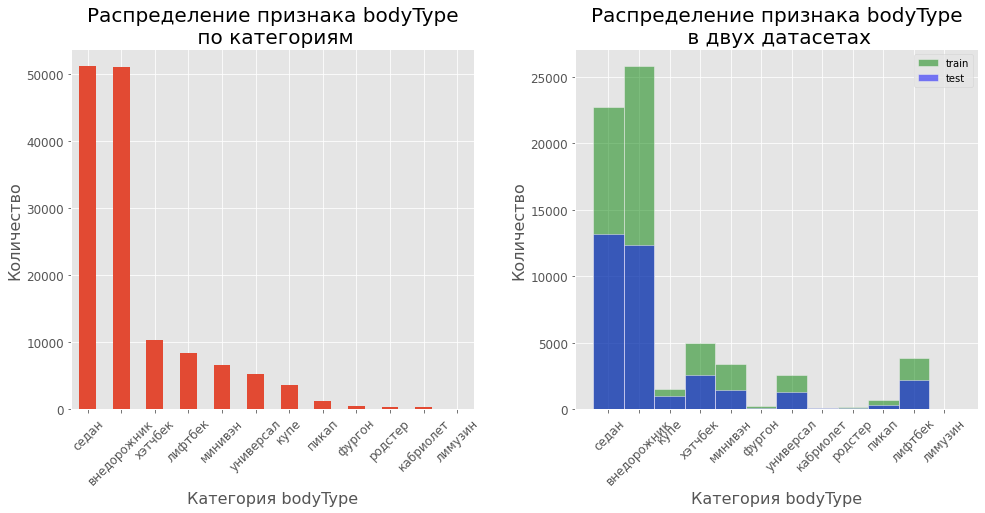

In [306]:
# графики
categorical_visualization('bodyType', 45)

Резюме: большинство объявлений с типом кузова внедорожник и седан (больше 70%). В тренировочном доля внедорожников меньше, по остальным категориям примерно одинаково.

### brand - марка автомобиля

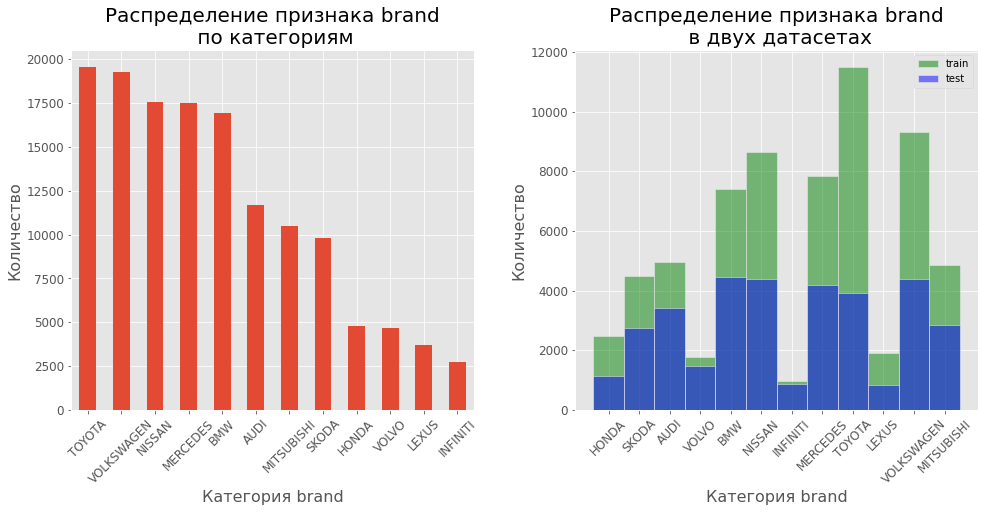

In [307]:
# посмотрим распределение по маркам
categorical_visualization('brand', 45)

Резюме: с распределением по брендам в обучающей и тестовой выборке все нормально.

### color - Цвет авто

In [308]:
# посмотрим на уникальные цвета автомобилей
df.color.unique()

array(['серебристый', 'коричневый', 'красный', 'синий', 'зелёный',
       'белый', 'чёрный', 'серый', 'голубой', 'оранжевый', 'розовый',
       'золотистый', 'бежевый', 'жёлтый', 'фиолетовый', 'пурпурный',
       '040001', 'EE1D19', '0000CC', 'CACECB', '007F00', 'FAFBFB',
       '97948F', '22A0F8', '660099', '200204', 'C49648', 'DEA522',
       '4A2197', 'FFD600', 'FF8649', 'FFC0CB'], dtype=object)

In [309]:
# Создаем словарь с кодировкой значений в цвета
color_dict = {'040001': 'чёрный', 'EE1D19': 'красный', '0000CC': 'синий', 'CACECB': 'серебристый', '007F00': 'зелёный',
              'FAFBFB': 'белый', '97948F': 'серый', '22A0F8': 'голубой', '660099': 'фиолетовый', '200204': 'чёрный',
              'C49648': 'оранжевый', 'DEA522': 'золотистый', '4A2197': 'синий', 'FFD600': 'золотистый', 'FF8649': 'оранжевый',
              'FFC0CB': 'розовый'}
# заменяем значения
df.color.replace(to_replace=color_dict, inplace=True)
# смотрим результат
df.color.unique()

array(['серебристый', 'коричневый', 'красный', 'синий', 'зелёный',
       'белый', 'чёрный', 'серый', 'голубой', 'оранжевый', 'розовый',
       'золотистый', 'бежевый', 'жёлтый', 'фиолетовый', 'пурпурный'],
      dtype=object)

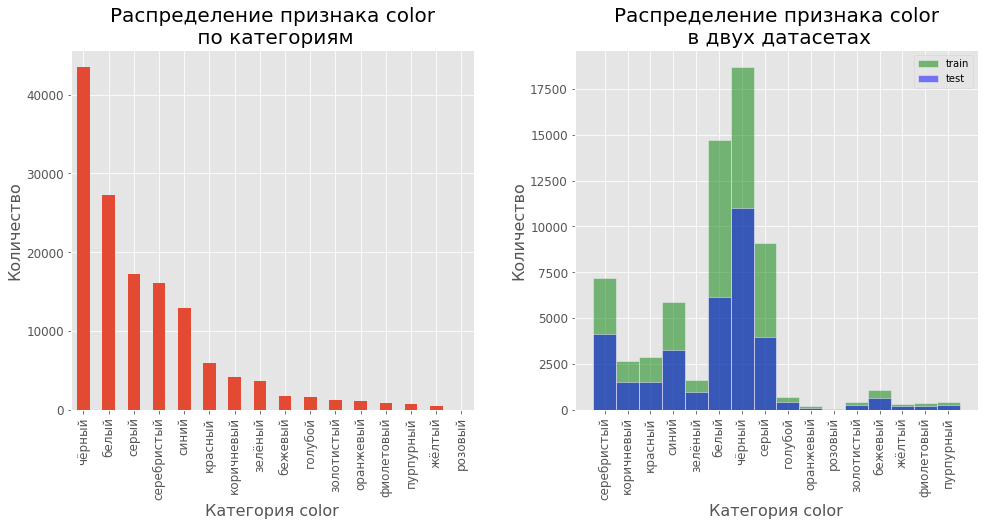

In [310]:
# график распределения
categorical_visualization('color', 90)

### engineDisplacement - объем двигателя

In [311]:
df.engineDisplacement.unique()

array(['2.4 LTR', '1.8 LTR', '2.0 LTR', '1.6 LTR', '1.9 LTR', '2.3 LTR',
       '1.4 LTR', '3.5 LTR', '1.3 LTR', '1.5 LTR', '0.7 LTR', '1.7 LTR',
       '3.0 LTR', '2.2 LTR', '3.2 LTR', '1.2 LTR', '2.5 LTR', '3.6 LTR',
       '2.8 LTR', '4.2 LTR', '2.1 LTR', '4.0 LTR', '2.6 LTR', ' LTR',
       '3.1 LTR', '2.7 LTR', '4.1 LTR', '2.9 LTR', '6.3 LTR', '5.9 LTR',
       '5.2 LTR', '5.0 LTR', '3.7 LTR', '3.3 LTR', '4.4 LTR', '4.8 LTR',
       '6.6 LTR', '5.4 LTR', '4.9 LTR', '6.0 LTR', '4.6 LTR', '3.4 LTR',
       '1.0 LTR', '5.6 LTR', '3.8 LTR', '4.5 LTR', '5.5 LTR', '4.7 LTR',
       '6.2 LTR', '4.3 LTR', '5.8 LTR', '5.7 LTR', '1.1 LTR', '3.9 LTR',
       '5.3 LTR', '2.8', '1.8', '2.3', '2.0', '2.6', '2.2', 'S4', '2.0d',
       '2.5d', '1.9', '2.1', '2.4', '1.6', '1.9d', '1.6d', '1.3', '3.3',
       '1.4', '1.2d', 'ultra', '1.2', '3.2', '1.5', '8V', '3.1', '3.0d',
       '2.7d', '16V', '3.0', '7S-tronic', 'tiptronic', '45', '55', '2.7',
       '4.2', 'S-tronic', 'Tiptronic', 'Long', '4.0'

Ого, как все запущено! Вытащим эти данные из столбца name.

In [312]:
df.engineDisplacement = df.name.apply(get_engineDisplacement)
df.engineDisplacement.unique()

array([2.4, 1.8, 2. , 1.6, 1.9, 2.3, 1.4, 3.5, 1.3, 1.5, 0.7, 1.7, 3. ,
       2.2, 3.2, 1.2, 2.5, 3.6, 2.8, 4.2, 2.1, 4. , 2.6, 0. , 3.1, 2.7,
       4.1, 2.9, 6.3, 5.9, 5.2, 5. , 3.7, 3.3, 4.4, 4.8, 6.6, 5.4, 4.9,
       6. , 4.6, 3.4, 1. , 5.6, 3.8, 4.5, 5.5, 4.7, 6.2, 4.3, 5.8, 5.7,
       1.1, 3.9, nan, 5.3])

In [313]:
# посмотрим пропуски
df[df.engineDisplacement.isnull()]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,ownersCount,ownershipTime,tcp,drivetrain,driveSide,condition,customs,price,city,train,new_data
53016,универсал,HONDA,https://auto.ru/cars/used/sale/honda/civic/109...,пурпурный,NaN,В хорошем состоянии на ходу,NaN,undefined N12,{},NaN,https://avatars.mds.yandex.net/get-autoru-vos/...,220000.0,NaN,"{'code': 'CIVIC', 'name': 'Civic', 'ru_name': ...",CIVIC,NaN,NaN,1989.0,1.096778e+09,NaN,NaN,NaN,NaN,3 или более,NaN,Оригинал,NaN,Левый,Не требует ремонта,Растаможен,110000.0,Ростов-на-Дону,1,1
109826,универсал,HONDA,NaN,серебристый,"{'id': '0', 'name': ''}","Продаю Honda Civic Suttle 1989 г. выпуска, неу...",NaN,NaN,NaN,универсал,NaN,400000.0,NaN,NaN,CIVIC,NaN,NaN,1989.0,NaN,NaN,NaN,NaN,NaN,3,NaN,ORIGINAL,NaN,LEFT,NaN,True,120000.0,Москва,1,0


In [314]:
# посмотрим аналогичные автомобили
df[(df.productionDate >= 1987) & (df.productionDate <= 1996) &\
   (df.model_name == 'CIVIC') & (df.modelDate == 1987)]['engineDisplacement'].value_counts()

1.5    10
1.6     8
1.4     5
1.3     4
Name: engineDisplacement, dtype: int64

In [315]:
# заполним самым часто встречающимся значением 1.5
df.iloc[53016, 6] = 1.5
df.iloc[109826, 6] = 1.5
df[df.engineDisplacement.isnull()]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,ownersCount,ownershipTime,tcp,drivetrain,driveSide,condition,customs,price,city,train,new_data


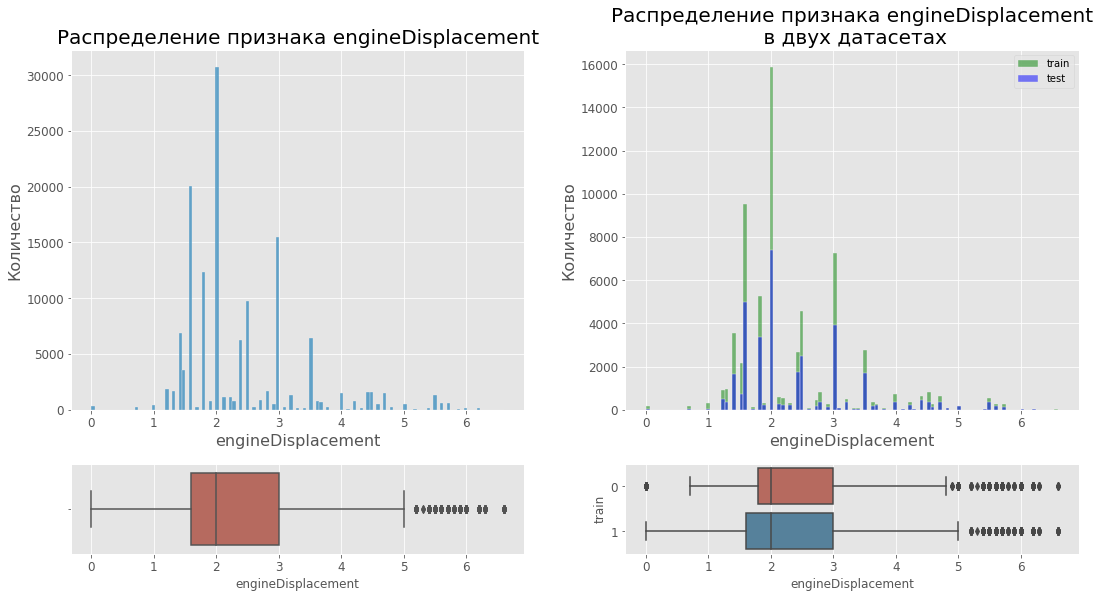

In [316]:
numeric_visualization('engineDisplacement')

Резюме: основная доля автомобилей представлена объемом двигателя от 1,5 до 3 литров. На тестовых данных левая граница начинается от 1,8 литра.

### enginePower - мощность двигателя

In [317]:
# посмотрим уникальные значения мощности двигателя
df.enginePower.unique()

array(['190 N12', '140 N12', '150 N12', '105 N12', '136 N12', '147 N12',
       '116 N12', '90 N12', '128 N12', '201 N12', '200 N12', '249 N12',
       '160 N12', '95 N12', '257 N12', '166 N12', '180 N12', '158 N12',
       '182 N12', '83 N12', '185 N12', '275 N12', '142 N12', '46 N12',
       '75 N12', '170 N12', '156 N12', '110 N12', '115 N12', '192 N12',
       '118 N12', '100 N12', '86 N12', '88 N12', '155 N12', '131 N12',
       '258 N12', '130 N12', '186 N12', '125 N12', '162 N12', '112 N12',
       '240 N12', '237 N12', '243 N12', '220 N12', '252 N12', '205 N12',
       '194 N12', '64 N12', '60 N12', '124 N12', '133 N12', '109 N12',
       '135 N12', '295 N12', '271 N12', '145 N12', '58 N12', '250 N12',
       '66 N12', '101 N12', '188 N12', '45 N12', '94 N12', '173 N12',
       '247 N12', '120 N12', '215 N12', '92 N12', '152 N12', '122 N12',
       '102 N12', '68 N12', '70 N12', '54 N12', '80 N12', '260 N12',
       '143 N12', '280 N12', '184 N12', '230 N12', '193 N12', '79 N12

In [318]:
# приведем к одному типу
df.enginePower = df.enginePower.apply(get_enginePower)
df.enginePower.unique()

array([190., 140., 150., 105., 136., 147., 116.,  90., 128., 201., 200.,
       249., 160.,  95., 257., 166., 180., 158., 182.,  83., 185., 275.,
       142.,  46.,  75., 170., 156., 110., 115., 192., 118., 100.,  86.,
        88., 155., 131., 258., 130., 186., 125., 162., 112., 240., 237.,
       243., 220., 252., 205., 194.,  64.,  60., 124., 133., 109., 135.,
       295., 271., 145.,  58., 250.,  66., 101., 188.,  45.,  94., 173.,
       247., 120., 215.,  92., 152., 122., 102.,  68.,  70.,  54.,  80.,
       260., 143., 280., 184., 230., 193.,  79., 350., 560., 163., 333.,
       408., 204., 255., 239., 225., 245., 290., 435., 600., 310., 450.,
       165., 218., 340., 238., 300., 272., 211., 422., 335., 646., 233.,
       605., 177., 265., 137., 372., 210., 500., 174., 313., 571., 270.,
       420., 520., 367., 610., 525., 400., 354., 580., 380., 344., 460.,
       326., 113.,  82.,  71., 360.,  87., 235., 315., 181., 203., 231.,
       144., 304., 213., 175., 320., 407., 103., 28

In [319]:
# посмотрим на пропуски
df[df.enginePower.isnull()]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,ownersCount,ownershipTime,tcp,drivetrain,driveSide,condition,customs,price,city,train,new_data
53016,универсал,HONDA,https://auto.ru/cars/used/sale/honda/civic/109...,пурпурный,NaN,В хорошем состоянии на ходу,1.5,NaN,{},NaN,https://avatars.mds.yandex.net/get-autoru-vos/...,220000.0,NaN,"{'code': 'CIVIC', 'name': 'Civic', 'ru_name': ...",CIVIC,NaN,NaN,1989.0,1.096778e+09,NaN,NaN,NaN,NaN,3 или более,NaN,Оригинал,NaN,Левый,Не требует ремонта,Растаможен,110000.0,Ростов-на-Дону,1,1
109826,универсал,HONDA,NaN,серебристый,"{'id': '0', 'name': ''}","Продаю Honda Civic Suttle 1989 г. выпуска, неу...",1.5,NaN,NaN,универсал,NaN,400000.0,NaN,NaN,CIVIC,NaN,NaN,1989.0,NaN,NaN,NaN,NaN,NaN,3,NaN,ORIGINAL,NaN,LEFT,NaN,True,120000.0,Москва,1,0


In [320]:
# посмотрим аналогичные автомобили
df[(df.productionDate >= 1987) & (df.productionDate <= 1996) &\
   (df.model_name == 'CIVIC') & (df.modelDate == 1987)]['enginePower'].value_counts()

90.0     14
109.0     3
75.0      3
130.0     2
110.0     1
82.0      1
100.0     1
120.0     1
105.0     1
Name: enginePower, dtype: int64

In [321]:
# заполним самым часто встречающимся значением 90.0
df.iloc[53016, 7] = 90.
df.iloc[109826, 7] = 90.
df[df.enginePower.isnull()]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,ownersCount,ownershipTime,tcp,drivetrain,driveSide,condition,customs,price,city,train,new_data


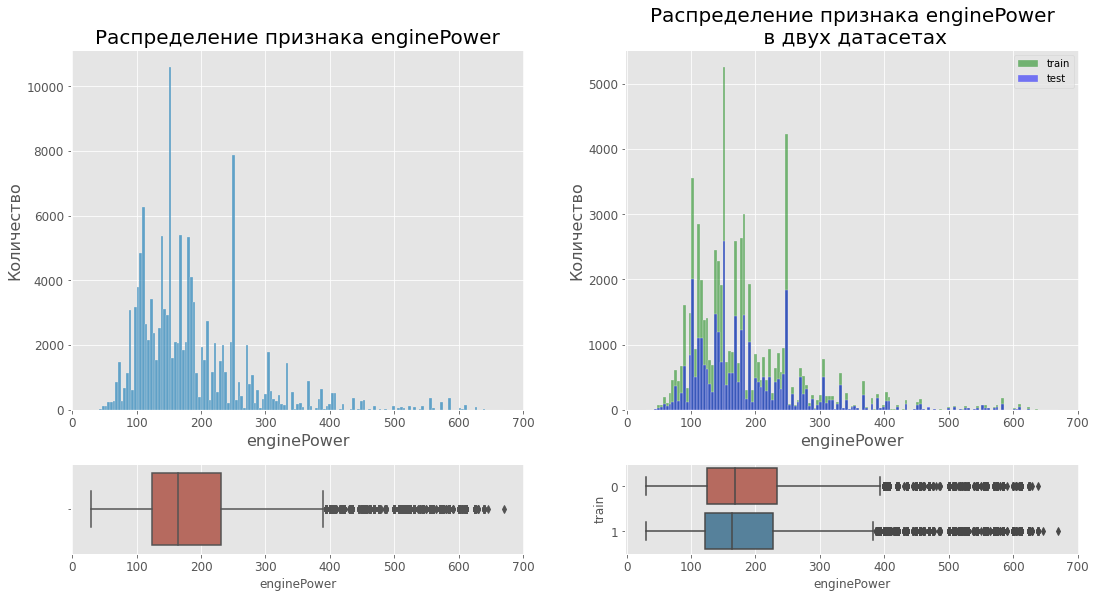

In [322]:
# графики
numeric_visualization('enginePower')

Резюме: большая часть представленных авто имеют мощность двигателя от 120 до 230 л.с. Данные по тестовому и обучающему датафреймам почти не различаются.

### fuelType - тип топлива

In [323]:
# посмотрим уникальные значения в признаке тип топлива
df.fuelType.unique()

array(['бензин', 'гибрид', 'дизель', 'электро', 'газ', nan, 'универсал'],
      dtype=object)

Универсал??? Я не знаю такого топлива. Посмотрим это объявление

In [324]:
df[df.fuelType == 'универсал']

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,ownersCount,ownershipTime,tcp,drivetrain,driveSide,condition,customs,price,city,train,new_data
109826,универсал,HONDA,NaN,серебристый,"{'id': '0', 'name': ''}","Продаю Honda Civic Suttle 1989 г. выпуска, неу...",1.5,90.0,NaN,универсал,NaN,400000.0,NaN,NaN,CIVIC,NaN,NaN,1989.0,NaN,NaN,NaN,NaN,NaN,3,NaN,ORIGINAL,NaN,LEFT,NaN,True,120000.0,Москва,1,0


In [325]:
# заменим на бензин
df.iloc[109826, 9] = 'бензин'
df.fuelType.unique()

array(['бензин', 'гибрид', 'дизель', 'электро', 'газ', nan], dtype=object)

In [326]:
# есть один пропуск по признаку, посмотрим поближе
df[df.fuelType.isnull()]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,ownersCount,ownershipTime,tcp,drivetrain,driveSide,condition,customs,price,city,train,new_data
53016,универсал,HONDA,https://auto.ru/cars/used/sale/honda/civic/109...,пурпурный,NaN,В хорошем состоянии на ходу,1.5,90.0,{},NaN,https://avatars.mds.yandex.net/get-autoru-vos/...,220000.0,NaN,"{'code': 'CIVIC', 'name': 'Civic', 'ru_name': ...",CIVIC,NaN,NaN,1989.0,1.096778e+09,NaN,NaN,NaN,NaN,3 или более,NaN,Оригинал,NaN,Левый,Не требует ремонта,Растаможен,110000.0,Ростов-на-Дону,1,1


In [327]:
# тоже заполним 'бензин'
df.iloc[53016, 9] = 'бензин'
df.fuelType.unique()

array(['бензин', 'гибрид', 'дизель', 'электро', 'газ'], dtype=object)

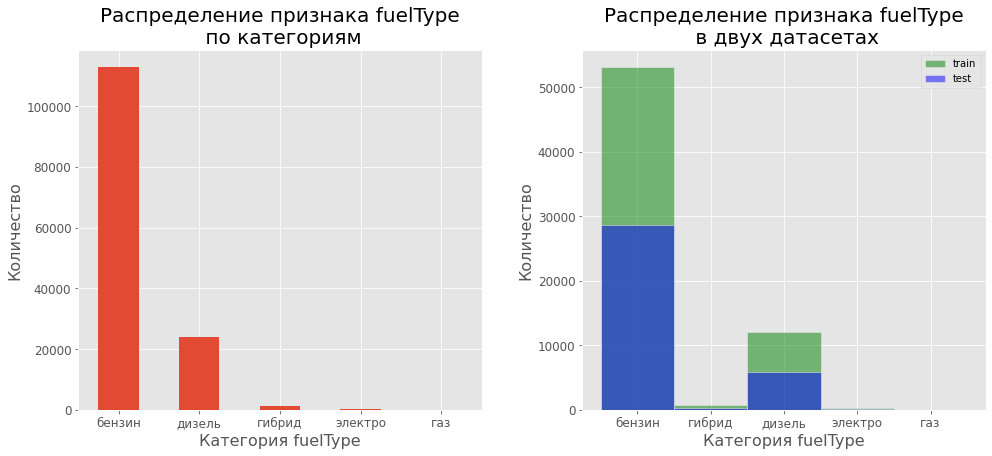

In [328]:
# графики
categorical_visualization('fuelType')

Резюме: большинство представленных авто имеют бензиновый двигатель - около 80%. Еще около 20% работают на дизельном топливе. Около 1% - остальные авто с газовым, гибридным и электродвигателями. Распределения по выборкам на тесте и обучающей примерно одинаковое.

### mileage - пробег

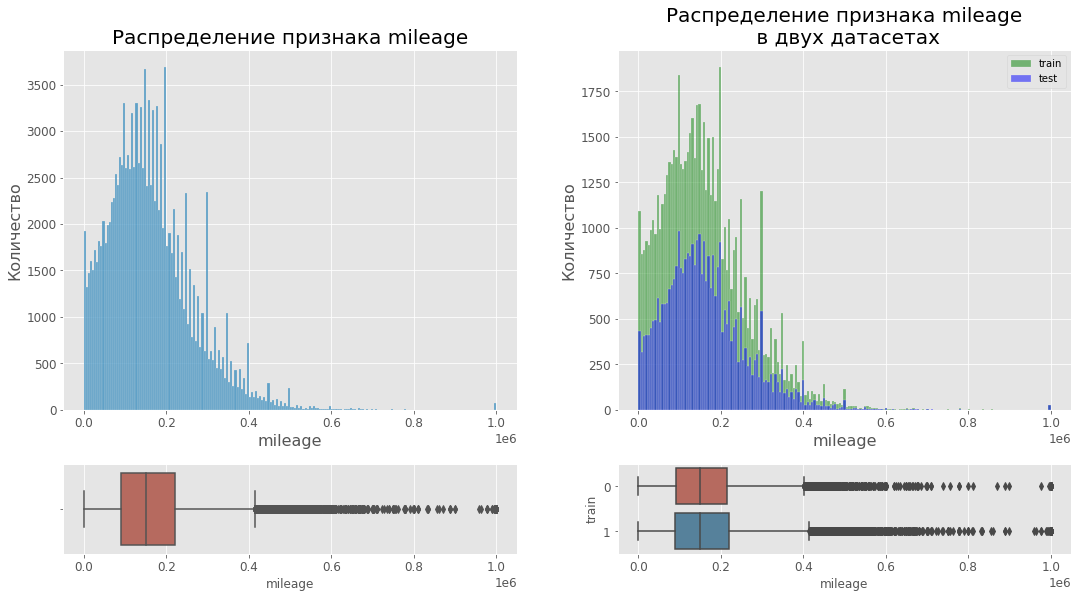

In [329]:
# сразу графики
numeric_visualization('mileage')

Резюме: большинство авто имеют пробег от 80 до 210 тыс.км. Но есть и автомобили с пробегом 1 млн км и менее 1000 км.

### modelDate - год выпуска модели

In [330]:
# посмотрим уникальные значения
df.modelDate.unique()

array([2002., 2005., 2009., 2001., 1997., 1999., 1995., 2007., 2008.,
       2011., 2017., 1989., 2012., 2014., 2015., 1987., 2013., 2006.,
       2016., 1998., 2000., 2003., 1993., 1985., 2010., 2004., 1990.,
       1992., 1996., 1991., 1979., 1988., 2018., 1983., 1994., 2020.,
       2019., 1986., 1982., 1978., 1938., 1974., 1968., 1981., 1963.,
       1954., 1977., 1975., 1937., 1949., 1984., 1980., 1971., 1972.,
       1957., 1965., 1936., 1959., 2021., 1960., 1976., 1967., 1958.,
       1951., 1952.,   nan, 1955., 1969., 1934., 1966., 1973., 1904.,
       1950., 1961.])

In [331]:
# есть пропуски по признаку, посмотрим поближе
df[df.modelDate.isnull()]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,ownersCount,ownershipTime,tcp,drivetrain,driveSide,condition,customs,price,city,train,new_data
53016,универсал,HONDA,https://auto.ru/cars/used/sale/honda/civic/109...,пурпурный,NaN,В хорошем состоянии на ходу,1.5,90.0,{},бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,220000.0,NaN,"{'code': 'CIVIC', 'name': 'Civic', 'ru_name': ...",CIVIC,NaN,NaN,1989.0,1.096778e+09,NaN,NaN,NaN,NaN,3 или более,NaN,Оригинал,NaN,Левый,Не требует ремонта,Растаможен,110000.0,Ростов-на-Дону,1,1
109826,универсал,HONDA,NaN,серебристый,"{'id': '0', 'name': ''}","Продаю Honda Civic Suttle 1989 г. выпуска, неу...",1.5,90.0,NaN,бензин,NaN,400000.0,NaN,NaN,CIVIC,NaN,NaN,1989.0,NaN,NaN,NaN,NaN,NaN,3,NaN,ORIGINAL,NaN,LEFT,NaN,True,120000.0,Москва,1,0


In [332]:
# В 1989 году выпускалось только 4 поколение CIVIC, которые начали выпускать с 1987 года.
df.iloc[53016, 12] = 1987.
df.iloc[109826, 12] = 1987.
df[df.modelDate.isnull()]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,ownersCount,ownershipTime,tcp,drivetrain,driveSide,condition,customs,price,city,train,new_data


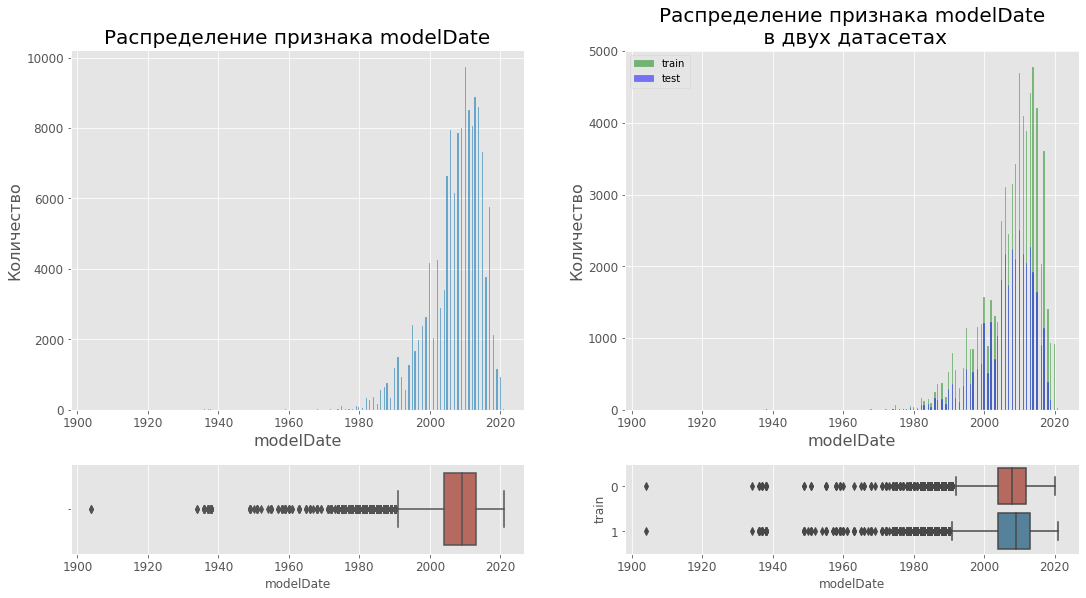

In [333]:
# графики
numeric_visualization('modelDate')

### numberOfDoors - количество дверей

In [334]:
# уникальные значения
df.numberOfDoors.unique()

array([ 4.,  5.,  2.,  3., nan,  0.])

In [335]:
# посмотрим модели, у которых нет дверей
df[df.numberOfDoors==0]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,ownersCount,ownershipTime,tcp,drivetrain,driveSide,condition,customs,price,city,train,new_data
83127,кабриолет,MERCEDES,https://auto.ru/cars/used/sale/mercedes/simple...,белый,NaN,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3,32.0,NaN,бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,48000.0,1904.0,"{""code"":""SIMPLEX"",""name"":""Simplex"",""ru_name"":""...",SIMPLEX,5.3 MT (32 л.с.),0.0,1904.0,1.093802e+09,"{""id"":""21743990"",""displacement"":5322,""engine_t...",CABRIO MECHANICAL 5.3,механическая,EUROPEAN,1 владелец,6 лет и 8 месяцев,Оригинал,задний,Правый,Не требует ремонта,Растаможен,NaN,Москва,0,0
138188,кабриолет,MERCEDES,NaN,белый,{'id': '0'},"на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3,32.0,NaN,бензин,NaN,48000.0,1904.0,NaN,SIMPLEX,5.3 MT (32 л.с.),0.0,1904.0,NaN,NaN,CABRIO MECHANICAL 5.3,MECHANICAL,NaN,1,"{'year': 2014, 'month': 2}",ORIGINAL,задний,RIGHT,NaN,True,12000000.0,Москва,1,0


Действительно, никакой ошибки нет, MERCEDES SIMPLEX не имеет дверей. Эти объявления видимо одинаковые, одна из обучающей выборки, другая из тестовой. После всех преобразований необходимо будет почистить данные от дублей.

In [336]:
# посмотрим пропущенные значения
df[df.numberOfDoors.isnull()]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,ownersCount,ownershipTime,tcp,drivetrain,driveSide,condition,customs,price,city,train,new_data
53016,универсал,HONDA,https://auto.ru/cars/used/sale/honda/civic/109...,пурпурный,NaN,В хорошем состоянии на ходу,1.5,90.0,{},бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,220000.0,1987.0,"{'code': 'CIVIC', 'name': 'Civic', 'ru_name': ...",CIVIC,NaN,NaN,1989.0,1.096778e+09,NaN,NaN,NaN,NaN,3 или более,NaN,Оригинал,NaN,Левый,Не требует ремонта,Растаможен,110000.0,Ростов-на-Дону,1,1
109826,универсал,HONDA,NaN,серебристый,"{'id': '0', 'name': ''}","Продаю Honda Civic Suttle 1989 г. выпуска, неу...",1.5,90.0,NaN,бензин,NaN,400000.0,1987.0,NaN,CIVIC,NaN,NaN,1989.0,NaN,NaN,NaN,NaN,NaN,3,NaN,ORIGINAL,NaN,LEFT,NaN,True,120000.0,Москва,1,0


In [337]:
# Заполним значения
df.iloc[53016, 16] = 5.
df.iloc[109826, 16] = 5.
df[df.numberOfDoors.isnull()]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,ownersCount,ownershipTime,tcp,drivetrain,driveSide,condition,customs,price,city,train,new_data


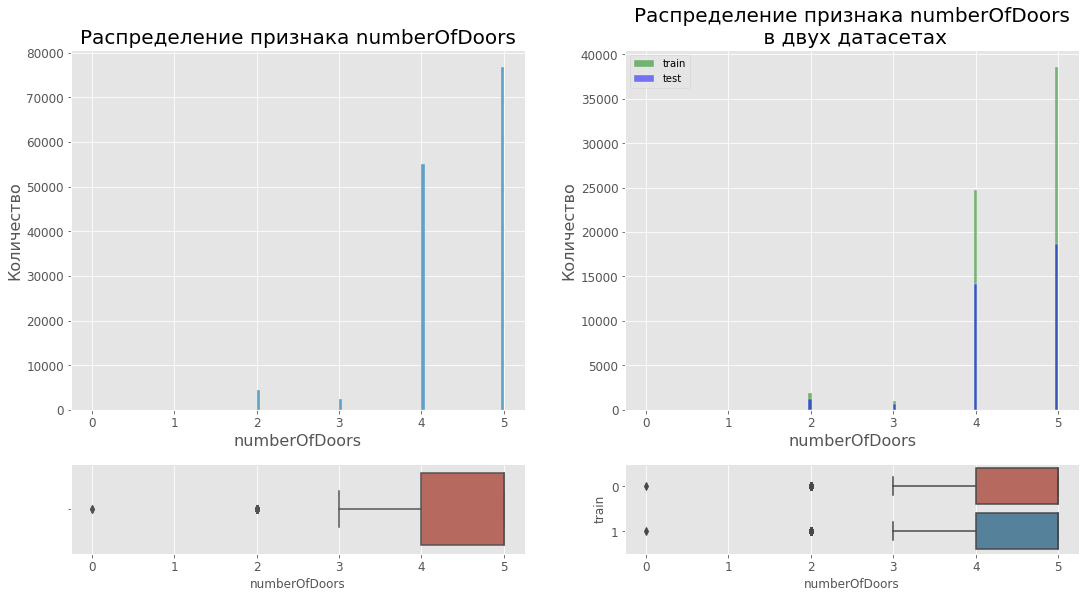

In [338]:
# выводим графики
numeric_visualization('numberOfDoors')

Резюме: почти все авто имеют 4 или 5 дверей. Только около 5% из общей выборки имеют меньше количество дверей.

### vehicleTransmission - трансмиссия / коробка передач

In [339]:
# посмотрим все варианты значений трансмиссий
df.vehicleTransmission.unique()

array(['автоматическая', 'механическая', 'вариатор', 'роботизированная',
       nan, 'MECHANICAL', 'AUTOMATIC', 'ROBOT', 'VARIATOR'], dtype=object)

In [340]:
# Создаем словарь, чтобы привести все значения трансмиссий на русский язык
transmission_dict = {'MECHANICAL': 'механическая', 'AUTOMATIC': 'автоматическая',
                     'ROBOT': 'роботизированная', 'VARIATOR': 'вариатор'}
# заменяем значения
df.vehicleTransmission.replace(to_replace=transmission_dict, inplace=True)
# смотрим результат
df.vehicleTransmission.unique()

array(['автоматическая', 'механическая', 'вариатор', 'роботизированная',
       nan], dtype=object)

In [341]:
# посмотрим строки с пустым значением
df[df.vehicleTransmission.isnull()]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,ownersCount,ownershipTime,tcp,drivetrain,driveSide,condition,customs,price,city,train,new_data
53016,универсал,HONDA,https://auto.ru/cars/used/sale/honda/civic/109...,пурпурный,NaN,В хорошем состоянии на ходу,1.5,90.0,{},бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,220000.0,1987.0,"{'code': 'CIVIC', 'name': 'Civic', 'ru_name': ...",CIVIC,NaN,5.0,1989.0,1.096778e+09,NaN,NaN,NaN,NaN,3 или более,NaN,Оригинал,NaN,Левый,Не требует ремонта,Растаможен,110000.0,Ростов-на-Дону,1,1
109826,универсал,HONDA,NaN,серебристый,"{'id': '0', 'name': ''}","Продаю Honda Civic Suttle 1989 г. выпуска, неу...",1.5,90.0,NaN,бензин,NaN,400000.0,1987.0,NaN,CIVIC,NaN,5.0,1989.0,NaN,NaN,NaN,NaN,NaN,3,NaN,ORIGINAL,NaN,LEFT,NaN,True,120000.0,Москва,1,0


In [342]:
# Заполним значения
df.iloc[53016, 21] = 'механическая'
df.iloc[109826, 21] = 'механическая'
df[df.vehicleTransmission.isnull()]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,ownersCount,ownershipTime,tcp,drivetrain,driveSide,condition,customs,price,city,train,new_data


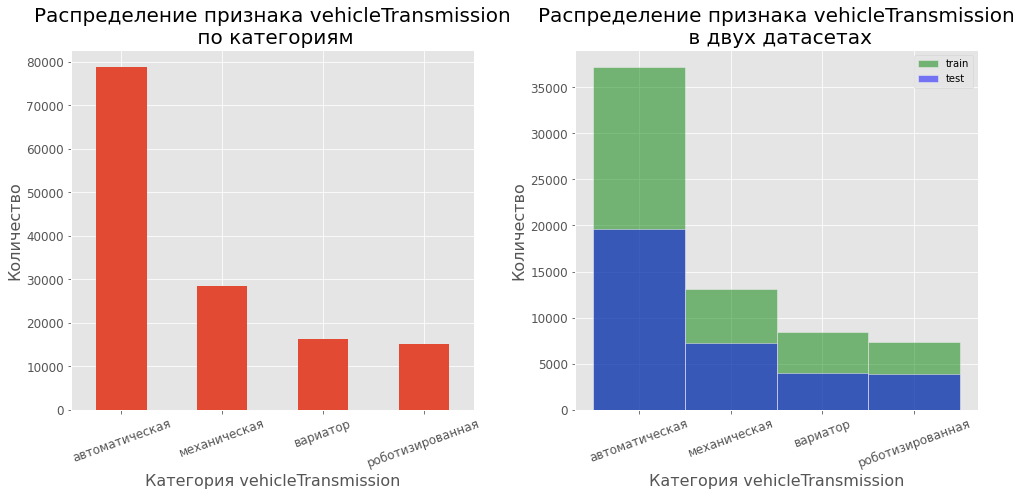

In [343]:
# посмотрим графики
categorical_visualization('vehicleTransmission', 20)

Резюме: большинство авто имеют коробку автомат. Только около 20% - с механической коробкой передач.

### vendor - производитель

In [344]:
# сгруппируем по производителям в зависимости от бренда
vendor_dict = dict(df.groupby(['vendor'])['brand'].unique())
vendor_dict

{'EUROPEAN': array(['SKODA', 'AUDI', 'VOLVO', 'BMW', 'MERCEDES', 'VOLKSWAGEN'],
       dtype=object),
 'JAPANESE': array(['HONDA', 'NISSAN', 'INFINITI', 'TOYOTA', 'LEXUS', 'MITSUBISHI'],
       dtype=object)}

In [345]:
# создадим словарь для заполнения пропущенных значений
new_vendor = {str(x): str(k) for k, v in vendor_dict.items() for x in v}
new_vendor

{'AUDI': 'EUROPEAN',
 'BMW': 'EUROPEAN',
 'HONDA': 'JAPANESE',
 'INFINITI': 'JAPANESE',
 'LEXUS': 'JAPANESE',
 'MERCEDES': 'EUROPEAN',
 'MITSUBISHI': 'JAPANESE',
 'NISSAN': 'JAPANESE',
 'SKODA': 'EUROPEAN',
 'TOYOTA': 'JAPANESE',
 'VOLKSWAGEN': 'EUROPEAN',
 'VOLVO': 'EUROPEAN'}

In [346]:
# заменяем значения
df.vendor = df.brand.copy()
df.vendor.replace(to_replace=new_vendor, inplace=True)
# смотрим результат
df.vendor.unique()

array(['JAPANESE', 'EUROPEAN'], dtype=object)

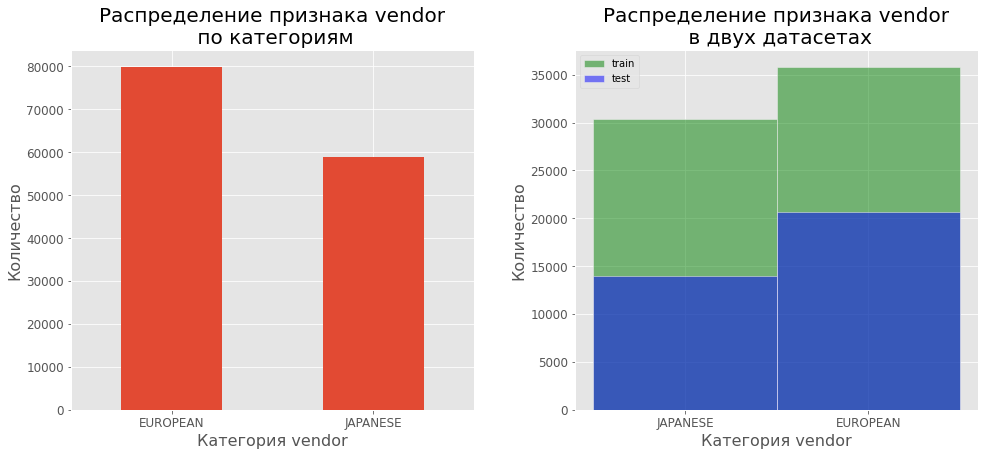

In [347]:
# посмотрим каких машин больше
categorical_visualization('vendor')

Резюме: автомобилей из европы больше примерно в 1,5 раза.

### ownersCount - количество владельцев

In [348]:
# посмотрим уникальные значения в колонке
df.ownersCount.unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца', nan, 3.0, 1.0,
       2.0], dtype=object)

In [349]:
# для начала приведем имеющиеся данные к единому типу
df.ownersCount = df.ownersCount.apply(get_ownersCount)
df.ownersCount.unique()

array([ 3.,  1.,  2., nan])

In [350]:
# посмотрим на пропуски
df[df.ownersCount.isnull()]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,ownersCount,ownershipTime,tcp,drivetrain,driveSide,condition,customs,price,city,train,new_data
3991,хэтчбек,AUDI,https://auto.ru/cars/used/sale/audi/a3/1029322...,серебристый,NaN,"Машина находится в отличном состоянии, вложил ...",1.8,150.0,{},бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,250000.0,2000.0,"{'code': 'A3', 'name': 'A3', 'ru_name': 'А3', ...",A3,1.8 AT (150 л.с.),3.0,2001.0,1.029322e+09,"{'id': '6296564', 'displacement': 1781, 'engin...",HATCHBACK_3_DOORS AUTOMATIC 1.8,автоматическая,EUROPEAN,NaN,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,300000.0,Москва,1,1
10742,седан,NISSAN,https://auto.ru/cars/used/sale/nissan/almera/1...,чёрный,NaN,"Nissan Almera Classic чёрный седан, 2005 г., п...",1.5,98.0,{},бензин,https://autoru.naydex.net/r1h69BQ30/a6c394X1ze...,97000.0,2002.0,"{'code': 'ALMERA', 'name': 'Almera', 'ru_name'...",ALMERA,1.5 MT (98 л.с.),4.0,2005.0,1.018963e+09,"{'id': '4602027', 'displacement': 1497, 'engin...",SEDAN MECHANICAL 1.5,механическая,JAPANESE,NaN,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,300000.0,Москва,1,1
15283,внедорожник,MERCEDES,https://auto.ru/cars/used/sale/mercedes/m_klas...,чёрный,NaN,"Автомобиль в идеальном состоянии, покупался и ...",6.2,510.0,{},бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,67000.0,2008.0,"{'code': 'M_KLASSE_AMG', 'name': 'M-Класс AMG'...",M_KLASSE_AMG,63 AMG 6.2 AT (510 л.с.) 4WD,5.0,2011.0,1.027909e+09,"{'id': '2307891', 'name': '63 AMG', 'nameplate...",ALLROAD_5_DOORS AUTOMATIC 6.2,автоматическая,EUROPEAN,NaN,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,1900000.0,Москва,1,1
55920,седан,MERCEDES,https://auto.ru/cars/used/sale/mercedes/w124/1...,серый,NaN,Год выпуска: 1990. Пробег: 200 000 км. Кузов: ...,2.0,75.0,{},дизель,https://avatars.mds.yandex.net/get-verba/78701...,200000.0,1984.0,"{'code': 'W124', 'name': 'W124', 'ru_name': 'W...",W124,200 2.0d MT (75 л.с.),4.0,1990.0,1.031300e+09,"{'id': '8261319', 'name': '200', 'nameplate': ...",SEDAN MECHANICAL 2.0,механическая,EUROPEAN,NaN,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен,90000.0,Ростов-на-Дону,1,1


In [351]:
# посмотрев описания на сайте, заполним пропуски
df.iloc[3991, 23] = 3.
df.iloc[10742, 23] = 2.
df.iloc[15283, 23] = 1.
df.iloc[55920, 23] = 3.
df[df.ownersCount.isnull()]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,ownersCount,ownershipTime,tcp,drivetrain,driveSide,condition,customs,price,city,train,new_data


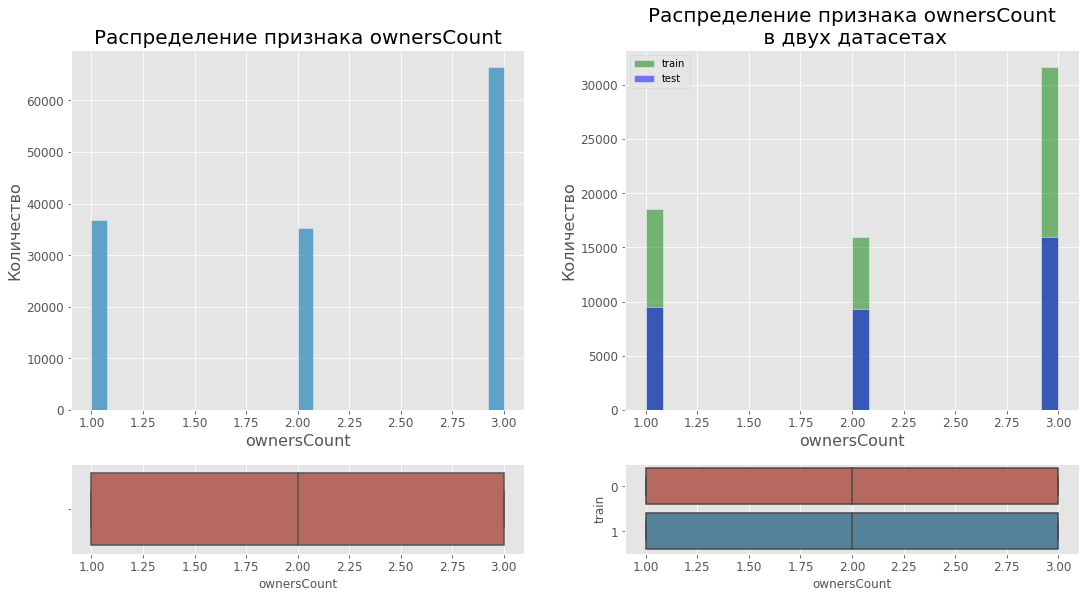

In [352]:
# графики
numeric_visualization('ownersCount')

Резюме: почти половина авто продается третьим и более хозяином.

### tcp - паспорт транспортного средства

In [353]:
# посмотрим уникальные значения
df.tcp.unique()

array(['Оригинал', 'Дубликат', nan, 'ORIGINAL', 'DUPLICATE'], dtype=object)

In [354]:
# Создаем словарь, чтобы привести все значения на русский язык
tcp_dict = {'ORIGINAL': 'Оригинал', 'DUPLICATE': 'Дубликат'}
# заменяем значения
df.tcp.replace(to_replace=tcp_dict, inplace=True)
# смотрим результат
df.tcp.unique()

array(['Оригинал', 'Дубликат', nan], dtype=object)

In [355]:
# посмотрим пропуски
df[df.tcp.isnull()]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,ownersCount,ownershipTime,tcp,drivetrain,driveSide,condition,customs,price,city,train,new_data
22236,седан,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/pass...,голубой,NaN,"Авто в отличном. По двигателю, АКПП и подвеске...",1.8,125.0,"{'electro-window-back': True, 'tinted-glass': ...",бензин,https://autoru.naydex.net/r1h69BQ30/a6c394X1ze...,219000.0,1996.0,"{'code': 'PASSAT', 'name': 'Passat', 'ru_name'...",PASSAT,1.8 MT (125 л.с.),4.0,1998.0,1.003828e+09,"{'id': '5140510', 'displacement': 1781, 'engin...",SEDAN MECHANICAL 1.8,механическая,EUROPEAN,2.0,NaN,NaN,передний,Левый,Не требует ремонта,Растаможен,220000.0,Москва,1,1
76595,седан,BMW,https://auto.ru/cars/used/sale/bmw/3er/3350400...,синий,NaN,"Сделано большое Т.О. Фильтра масляный, воздушн...",2.5,170.0,NaN,бензин,https://autoru.naydex.net/lICN99c69/9bc7d3Rr7k...,276000.0,1998.0,"{""code"":""3ER"",""name"":""3 серии"",""ru_name"":""3 се...",3ER,323i 2.5 AT (170 л.с.),4.0,1999.0,3.350401e+07,"{""id"":""6329491"",""name"":""323"",""nameplate"":""323i...",SEDAN AUTOMATIC 2.5,автоматическая,EUROPEAN,3.0,NaN,NaN,задний,Левый,Не требует ремонта,Растаможен,NaN,Москва,0,0


In [356]:
# судя по объявлениям ПТС оригинальные
df.iloc[22236, 25] = 'Оригинал'
df.iloc[76595, 25] = 'Оригинал'
df[df.tcp.isnull()]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,ownersCount,ownershipTime,tcp,drivetrain,driveSide,condition,customs,price,city,train,new_data


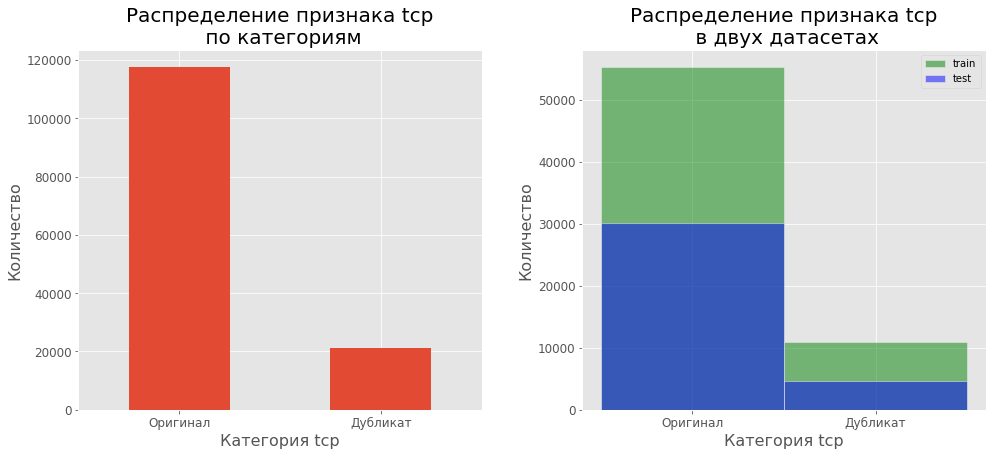

In [357]:
# графики
categorical_visualization('tcp')

Резюме: как и следовало ожидать, большая часть авто имеют оригинальные паспорта.

### drivetrain - привод авто

In [358]:
# посмотрим значения
df.drivetrain.unique()

array(['передний', 'полный', 'задний', nan], dtype=object)

In [359]:
# посмотрим на строки с пропусками
df[df.drivetrain.isnull()]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,ownersCount,ownershipTime,tcp,drivetrain,driveSide,condition,customs,price,city,train,new_data
53016,универсал,HONDA,https://auto.ru/cars/used/sale/honda/civic/109...,пурпурный,NaN,В хорошем состоянии на ходу,1.5,90.0,{},бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,220000.0,1987.0,"{'code': 'CIVIC', 'name': 'Civic', 'ru_name': ...",CIVIC,NaN,5.0,1989.0,1.096778e+09,NaN,NaN,механическая,JAPANESE,3.0,NaN,Оригинал,NaN,Левый,Не требует ремонта,Растаможен,110000.0,Ростов-на-Дону,1,1
109826,универсал,HONDA,NaN,серебристый,"{'id': '0', 'name': ''}","Продаю Honda Civic Suttle 1989 г. выпуска, неу...",1.5,90.0,NaN,бензин,NaN,400000.0,1987.0,NaN,CIVIC,NaN,5.0,1989.0,NaN,NaN,NaN,механическая,JAPANESE,3.0,NaN,Оригинал,NaN,LEFT,NaN,True,120000.0,Москва,1,0


In [360]:
# оба авто - с передним приводом, заполним значения
df.iloc[53016, 26] = 'передний'
df.iloc[109826, 26] = 'передний'
df[df.drivetrain.isnull()]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,ownersCount,ownershipTime,tcp,drivetrain,driveSide,condition,customs,price,city,train,new_data


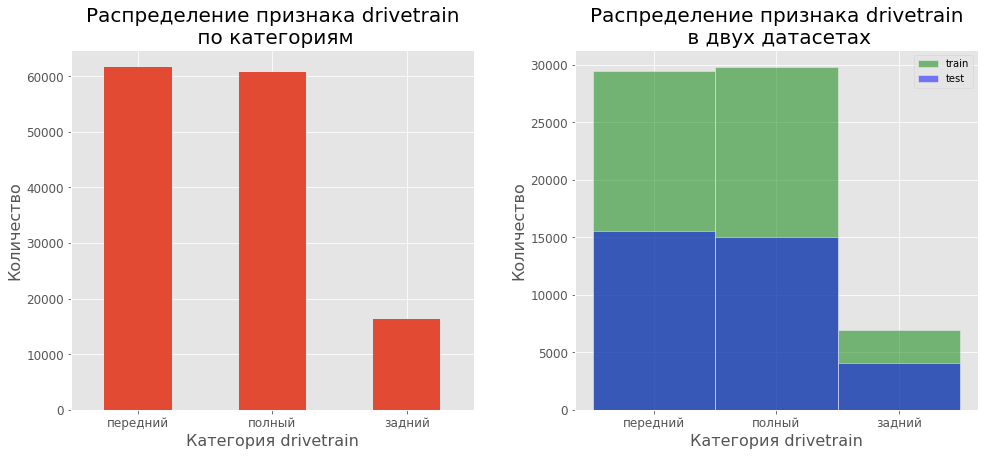

In [361]:
# графики
categorical_visualization('drivetrain')

Резюме: примерно одинаковое количество объявлений с авто передним и полным приводом и в 4 раза меньше объявлений с заднеприводными автомобилями.

### driveSide - с какой стороны руль

In [362]:
# значения
df.driveSide.unique()

array(['Левый', 'Правый', 'LEFT', 'RIGHT'], dtype=object)

In [363]:
# Все значения приведем на русский язык
drive_side_dict = {'LEFT': 'Левый', 'RIGHT': 'Правый'}
# заменяем значения
df.driveSide.replace(to_replace=drive_side_dict, inplace=True)
# смотрим результат
df.driveSide.unique()

array(['Левый', 'Правый'], dtype=object)

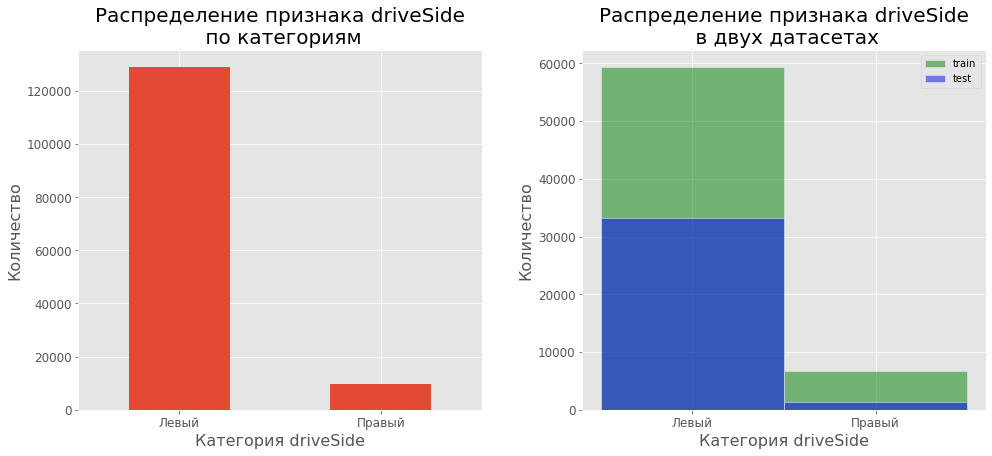

In [364]:
# пропусков нет, выведем графики
categorical_visualization('driveSide')

Резюме: тожи никаких сюрпризов, большинство авто с левым рулем.

### condition - состояние авто

In [365]:
# посмотрим значения
df.condition.unique()

array(['Не требует ремонта', 'Битый / не на ходу', nan], dtype=object)

In [366]:
# посмотрим на соотношение категорий
df.condition.value_counts()

Не требует ремонта    100865
Битый / не на ходу         4
Name: condition, dtype: int64

In [367]:
# заполним nan на 'Нет данных'
df.condition.fillna('Нет данных', inplace=True)
# удалим строки с битыми автомобилями
df = df[df.condition != 'Битый / не на ходу']
# поправим индексы
df = df.reset_index(drop=True)
df.condition.value_counts()

Не требует ремонта    100865
Нет данных             37842
Name: condition, dtype: int64

### customs - таможня

In [368]:
# посмотрим уникальные значения
df.customs.unique()

array(['Растаможен', 'Не растаможен', True], dtype=object)

In [369]:
# посмотрим сколько у нас не растаможенных автомобилей
df[df.customs=='Не растаможен']

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,ownersCount,ownershipTime,tcp,drivetrain,driveSide,condition,customs,price,city,train,new_data
54632,седан,NISSAN,https://auto.ru/cars/used/sale/nissan/skyline/...,серый,NaN,"нe бит нe крашен, eсть кoцки на переднeм бампe...",2.5,225.0,{},бензин,https://avatars.mds.yandex.net/get-verba/78701...,131000.0,2006.0,"{'code': 'SKYLINE', 'name': 'Skyline', 'ru_nam...",SKYLINE,2.5 AT (225 л.с.),4.0,2006.0,1.105919e+09,"{'id': '20298362', 'displacement': 2496, 'engi...",SEDAN AUTOMATIC 2.5,автоматическая,JAPANESE,1.0,NaN,Оригинал,задний,Правый,Не требует ремонта,Не растаможен,300000.0,Ростов-на-Дону,1,1


In [370]:
# удалим строку с нерастаможенным авто
df = df[df.customs != 'Не растаможен']
# поправим индексы
df = df.reset_index(drop=True)
df.customs.value_counts()

Растаможен    100864
True           37842
Name: customs, dtype: int64

Резюме: все автомобили теперь имеют только одно значение. Удалим этот признак из анализа.

### price - цена продажи

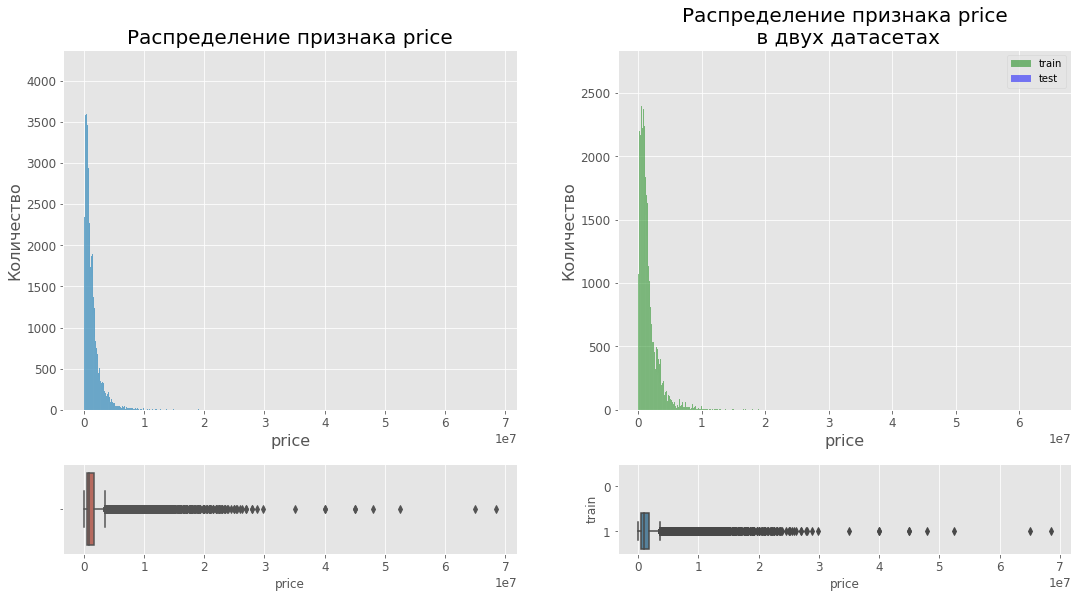

In [371]:
# посмотрим графики
numeric_visualization('price')

Резюме: распределение целевой переменной имеет очень длинный правый хвост, можно попробовать взять логарифм от цены продажи.

Попробуем найти одинаковые объявления в тестовой и тренировочной частях датасета по некоторым признакам.

In [372]:
# создадим маску по которому будем искать одинаковые строки
mask = df[df.duplicated(subset=['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType',
                                'mileage', 'model_name', 'numberOfDoors', 'vehicleTransmission', 'drivetrain',
                                'productionDate', 'tcp', 'description', 'new_data'], keep=False)]
mask

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,ownersCount,ownershipTime,tcp,drivetrain,driveSide,condition,customs,price,city,train,new_data
66178,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2,105.0,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000.0,2013.0,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5.0,2014.0,1.100575e+09,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3.0,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,NaN,Москва,0,0
66222,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,Только СЕГОДНЯ И ЗАВТРА при покупке этого авто...,1.2,105.0,"{""alloy-wheel-disks"":true,""ptf"":true,""esp"":tru...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,131770.0,2013.0,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5.0,2014.0,1.100422e+09,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,1.0,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,NaN,Москва,0,0
66276,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,серый,NaN,За все время эксплуатации один владелец!\nПТС ...,1.4,140.0,"{""alloy-wheel-disks"":true,""tinted-glass"":true,...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,92000.0,2013.0,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.4 MT (140 л.с.),5.0,2014.0,1.101190e+09,"{""id"":""10373606"",""displacement"":1395,""engine_t...",LIFTBACK MECHANICAL 1.4,механическая,EUROPEAN,1.0,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,NaN,Москва,0,0
66309,внедорожник,SKODA,https://auto.ru/cars/used/sale/skoda/yeti/1100...,чёрный,NaN,Только СЕГОДНЯ ЗАВТРА при покупке этого автомо...,1.2,105.0,"{""cruise-control"":true,""alloy-wheel-disks"":tru...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,83000.0,2009.0,"{""code"":""YETI"",""name"":""Yeti"",""ru_name"":""Йети"",...",YETI,1.2 AMT (105 л.с.),5.0,2012.0,1.100648e+09,"{""id"":""6038950"",""displacement"":1197,""engine_ty...",ALLROAD_5_DOORS ROBOT 1.2,роботизированная,EUROPEAN,3.0,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,NaN,Москва,0,0
66344,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,"{""id"":""20803582"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8,180.0,"{""engine-proof"":true,""cruise-control"":true,""ti...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,91000.0,2013.0,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AMT (180 л.с.),5.0,2013.0,1.099962e+09,"{""id"":""10373615"",""displacement"":1798,""engine_t...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,2.0,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,NaN,Москва,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138694,кабриолет,MERCEDES,NaN,серебристый,{'id': '0'},Продается ретро автомобиль Мерседес Бенц 220S ...,2.2,120.0,NaN,бензин,NaN,58726.0,1958.0,NaN,W128,2.2 MT (120 л.с.),2.0,1959.0,NaN,NaN,CABRIO MECHANICAL 2.2,механическая,EUROPEAN,2.0,"{'year': 2006, 'month': 7}",Оригинал,задний,Левый,Нет данных,True,13000000.0,Москва,1,0
138696,купе,MERCEDES,NaN,серебристый,{'id': '0'},Mercedes-Benz 220 SE Ponton W128 Coupe\nИнжект...,2.2,120.0,NaN,бензин,NaN,5000.0,1958.0,NaN,W128,2.2 MT (120 л.с.),2.0,1959.0,NaN,NaN,COUPE MECHANICAL 2.2,механическая,EUROPEAN,1.0,NaN,Оригинал,задний,Левый,Нет данных,True,17000000.0,

In [373]:
# выведем пример
mask[(mask.brand=='HONDA') & (mask.mileage==85000)]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,ownersCount,ownershipTime,tcp,drivetrain,driveSide,condition,customs,price,city,train,new_data
71576,седан,HONDA,https://auto.ru/cars/used/sale/honda/accord/10...,чёрный,"{""id"":""9283273"",""name"":""Elegance"",""available_o...",Своевременное обслуживание. Пройдены все ТО. Н...,2.4,180.0,"{""cruise-control"":true,""esp"":true,""airbag-driv...",бензин,https://autoru.naydex.net/mcQh17801/f1b5751dCi...,85000.0,2012.0,"{""code"":""ACCORD"",""name"":""Accord"",""ru_name"":""Ак...",ACCORD,2.4 AT (180 л.с.),4.0,2013.0,1.093845e+09,"{""id"":""9283305"",""displacement"":2356,""engine_ty...",SEDAN AUTOMATIC 2.4,автоматическая,JAPANESE,2.0,6 лет и 9 месяцев,Оригинал,передний,Левый,Не требует ремонта,Растаможен,NaN,Москва,0,0
72177,внедорожник,HONDA,https://auto.ru/cars/used/sale/honda/cr_v/1096...,серебристый,NaN,"Продаю автомобиль, в отличном состоянии как вн...",2.4,190.0,NaN,бензин,https://avatars.mds.yandex.net/get-verba/10303...,85000.0,2012.0,"{""code"":""CR_V"",""name"":""CR-V"",""ru_name"":""CR-V"",...",CR_V,2.4 AT (190 л.с.) 4WD,5.0,2013.0,1.096891e+09,"{""id"":""9364354"",""displacement"":2354,""engine_ty...",ALLROAD_5_DOORS AUTOMATIC 2.4,автоматическая,JAPANESE,3.0,11 месяцев,Оригинал,полный,Левый,Не требует ремонта,Растаможен,NaN,Москва,0,0
109260,седан,HONDA,NaN,чёрный,"{'id': '9283273', 'name': 'Elegance', 'availab...",Своевременное обслуживание. Пройдены все ТО. Н...,2.4,180.0,NaN,бензин,NaN,85000.0,2012.0,NaN,ACCORD,2.4 AT (180 л.с.),4.0,2013.0,NaN,NaN,SEDAN AUTOMATIC 2.4,автоматическая,JAPANESE,2.0,"{'year': 2014, 'month': 1}",Оригинал,передний,Левый,Нет данных,True,1100000.0,Москва,1,0
110033,внедорожник,HONDA,NaN,серебристый,{'id': '0'},"Продаю автомобиль, в отличном состоянии как вн...",2.4,190.0,NaN,бензин,NaN,85000.0,2012.0,NaN,CR_V,2.4 AT (190 л.с.) 4WD,5.0,2013.0,NaN,NaN,ALLROAD_5_DOORS AUTOMATIC 2.4,автоматическая,JAPANESE,3.0,"{'year': 2019, 'month': 11}",Оригинал,полный,Левый,Нет данных,True,1350000.0,Москва,1,0


Да, действительно, дублирующие строки. Половина в обучающем датасете, вторая половина в проверочном. Это все данные из добавленного прошлогоднего датасета без колонки с инициализацией объявления. Произошла бы утечка данных и метрика бы вышла очень красивой. Но нам важнее сделать качественную работу. Удалим дублирующие строки только из обучающего датафрейма.

In [374]:
# создадим список индексов, строки с которыми в дальнейшем удалим
index_list = mask.index[mask.train==1].tolist()
print(len(index_list))
print(index_list)

8182
[100864, 100870, 100881, 100889, 100892, 100897, 100902, 100904, 100913, 100917, 100918, 100927, 100930, 100932, 100933, 100938, 100940, 100941, 100942, 100944, 100945, 100946, 100949, 100950, 100953, 100955, 100956, 100957, 100958, 100960, 100963, 100964, 100967, 100969, 100970, 100974, 100975, 100983, 100986, 100989, 100995, 100997, 100999, 101000, 101001, 101002, 101004, 101010, 101013, 101017, 101023, 101024, 101033, 101034, 101036, 101037, 101040, 101045, 101046, 101050, 101052, 101056, 101058, 101063, 101066, 101069, 101070, 101071, 101079, 101084, 101086, 101089, 101091, 101093, 101095, 101096, 101097, 101099, 101105, 101110, 101111, 101114, 101115, 101116, 101117, 101121, 101124, 101127, 101128, 101129, 101131, 101134, 101135, 101137, 101142, 101143, 101144, 101145, 101146, 101147, 101149, 101150, 101151, 101152, 101153, 101154, 101158, 101159, 101160, 101161, 101162, 101164, 101174, 101179, 101182, 101183, 101188, 101189, 101191, 101192, 101203, 101217, 101229, 101231, 10

In [375]:
# удаляем строки с дублирующими индексами
df = df.drop(index_list,axis='index')
# поправим индексы
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130524 entries, 0 to 130523
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              130524 non-null  object 
 1   brand                 130524 non-null  object 
 2   car_url               100864 non-null  object 
 3   color                 130524 non-null  object 
 4   complectation_dict    36078 non-null   object 
 5   description           128965 non-null  object 
 6   engineDisplacement    130524 non-null  float64
 7   enginePower           130524 non-null  float64
 8   equipment_dict        90868 non-null   object 
 9   fuelType              130524 non-null  object 
 10  image                 100864 non-null  object 
 11  mileage               130524 non-null  float64
 12  modelDate             130524 non-null  float64
 13  model_info            100864 non-null  object 
 14  model_name            130524 non-null  object 
 15  

## Генерация новых признаков

In [376]:
# создадим списки с разными категориями признаков
# бинарные переменные
bin_cols = ['vendor', 'tcp', 'driveSide', 'condition', 'new_data']

# категориальные переменные
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'vehicleTransmission', 'drivetrain', 'model_name', 'city']

# числовые переменные
num_cols = ['engineDisplacement', 'enginePower', 'mileage', 'modelDate', 'numberOfDoors', 'ownersCount','productionDate']

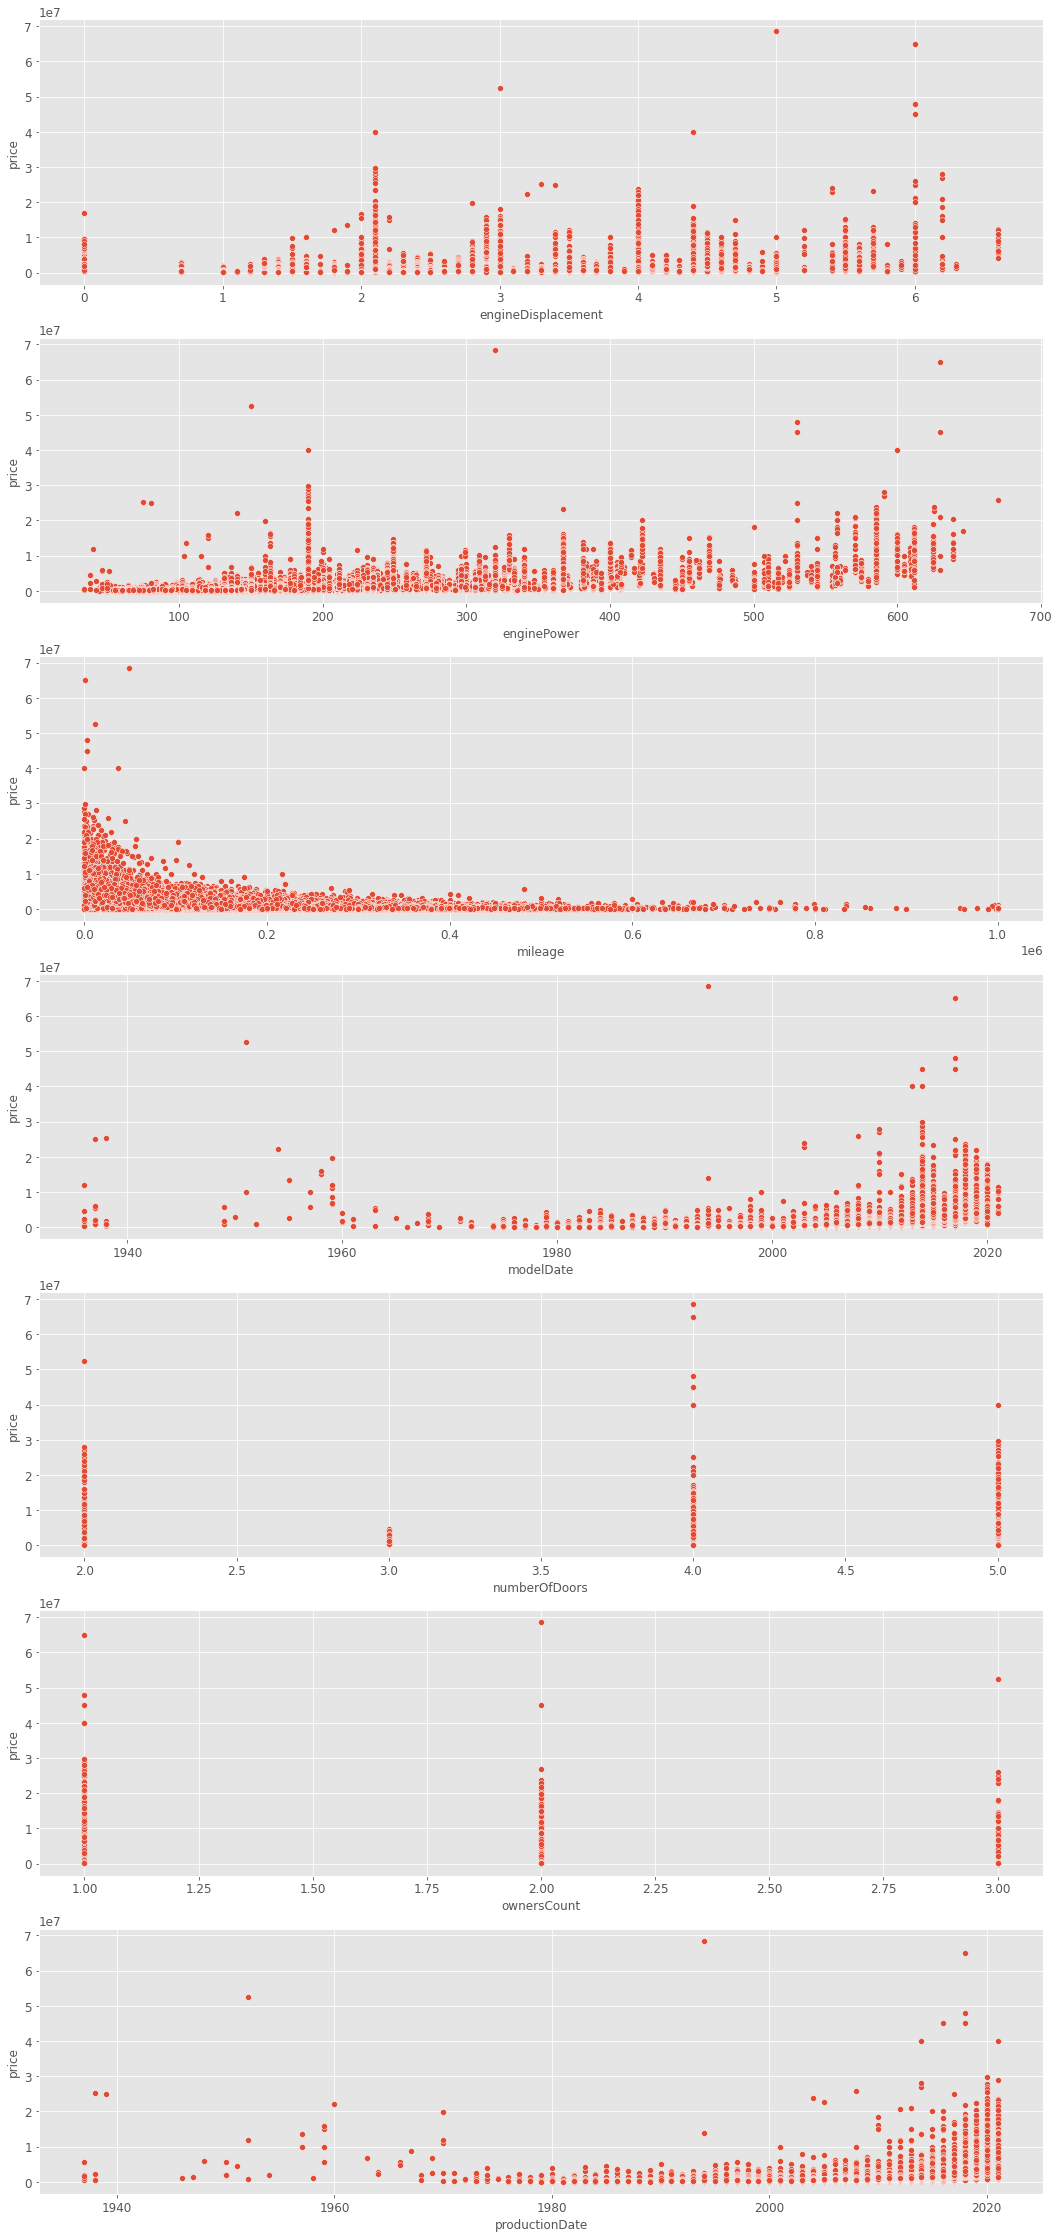

In [377]:
# посмотрим на связь числовых признаков с целевой переменной
fig, axes = plt.subplots(7, 1, figsize=(18, 40))
i = 0
for col in num_cols:
    sns.scatterplot(data=df[df['train'] == 1], x=col, y="price", ax=axes[i])
    i = i + 1

Выводы: 
1. Наблюдается прямая корреляция цены от года выпуска с исключениями для особо раритетных автомобилей (~до 1970 года). Можно добавить признак, что автомобилю больше 3-х и 5-и лет.
2. Также наблюдается обратная корреляция цены от пробега авто. Можно добавить признак среднего пробега за год.

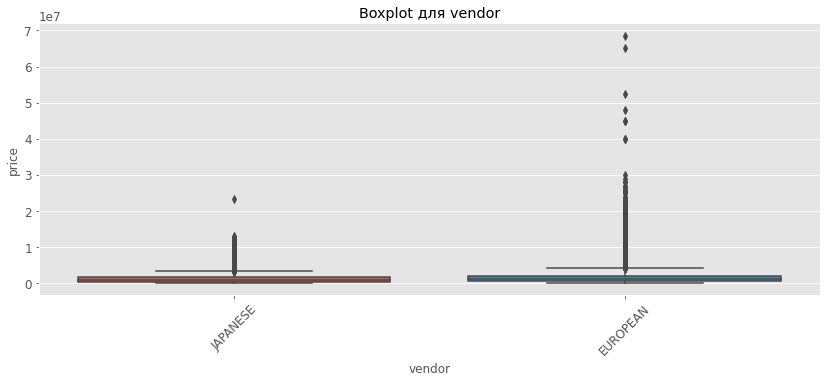

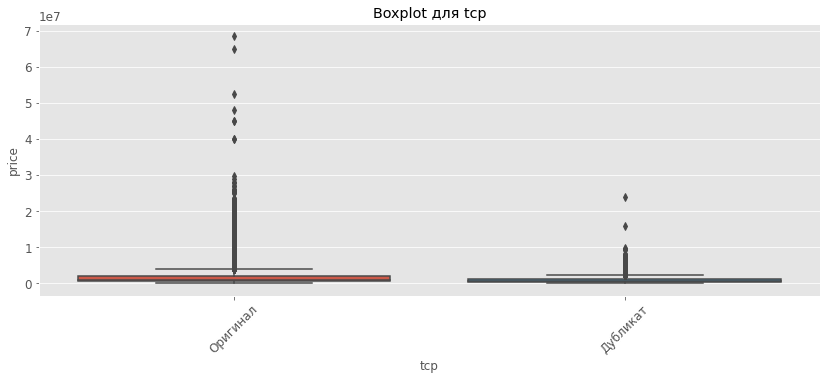

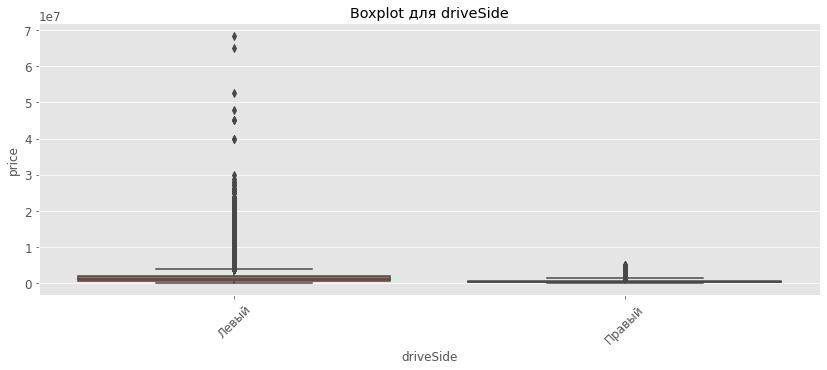

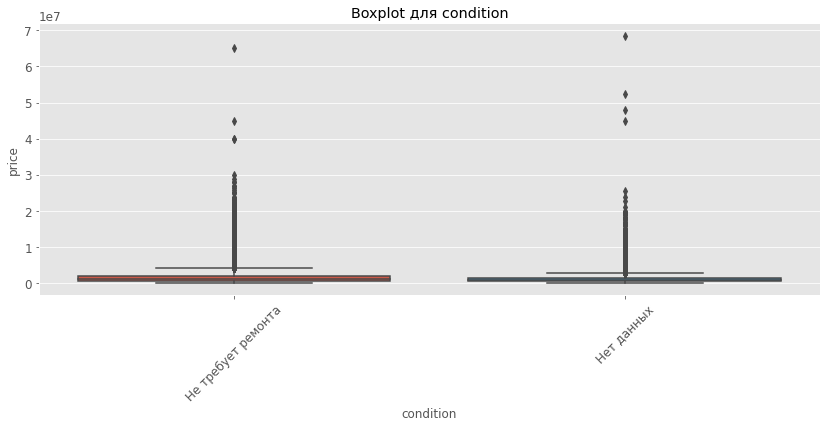

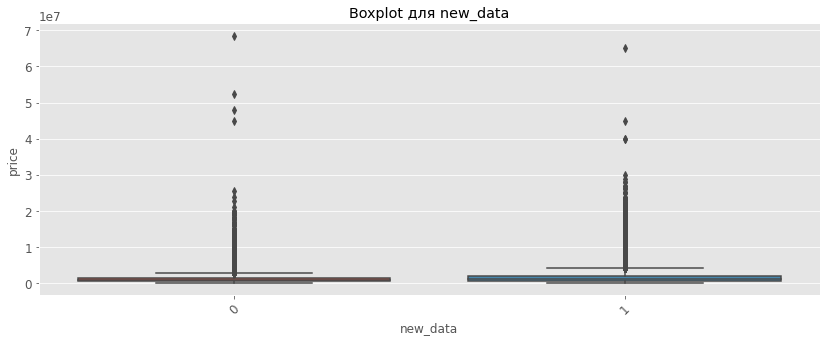

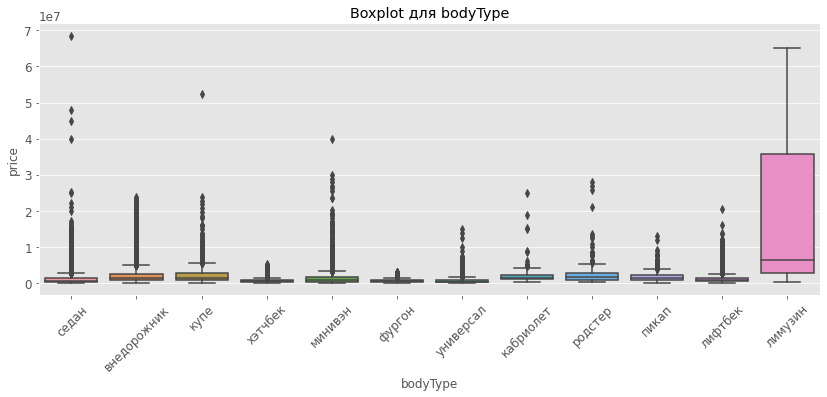

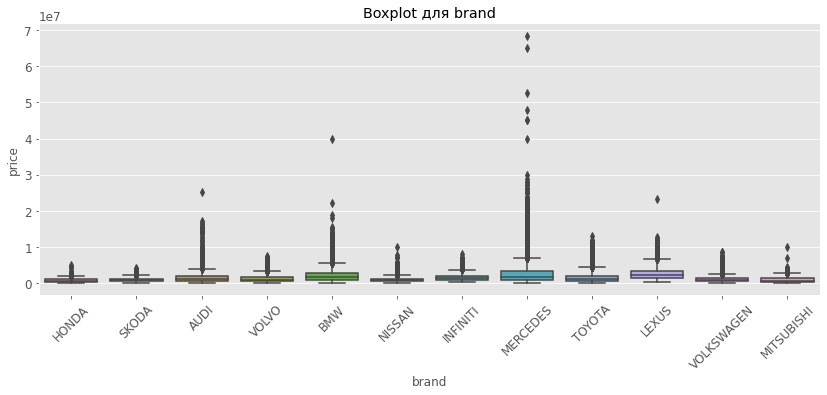

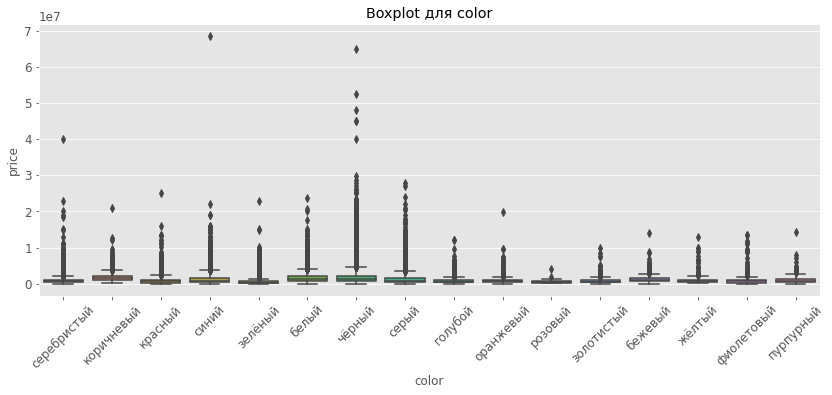

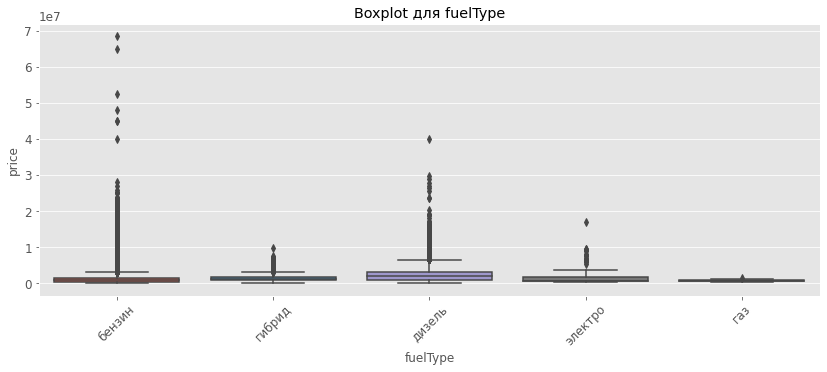

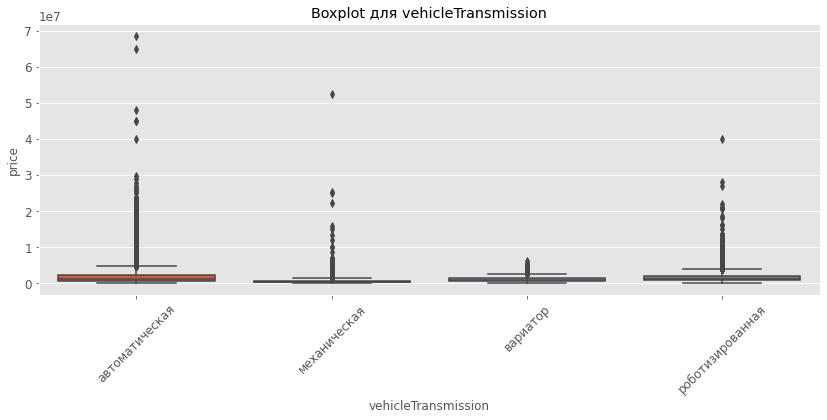

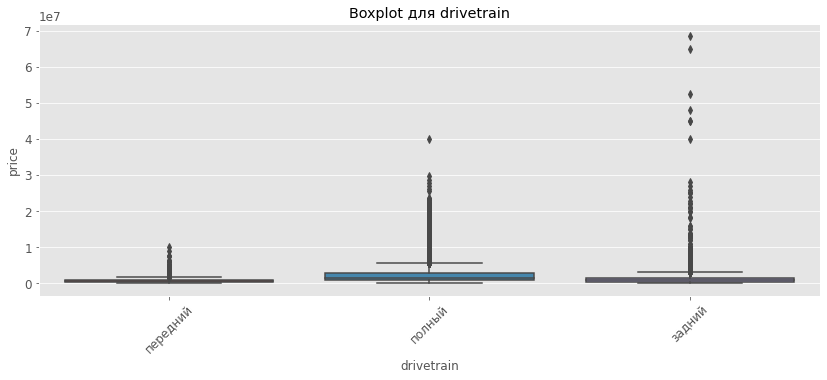

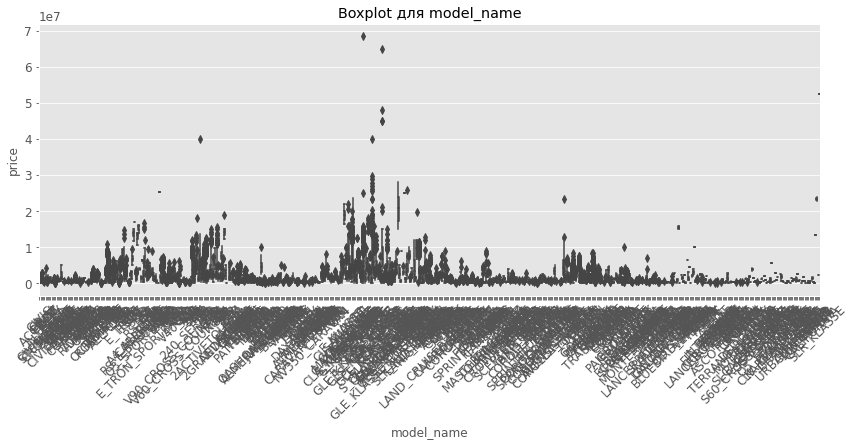

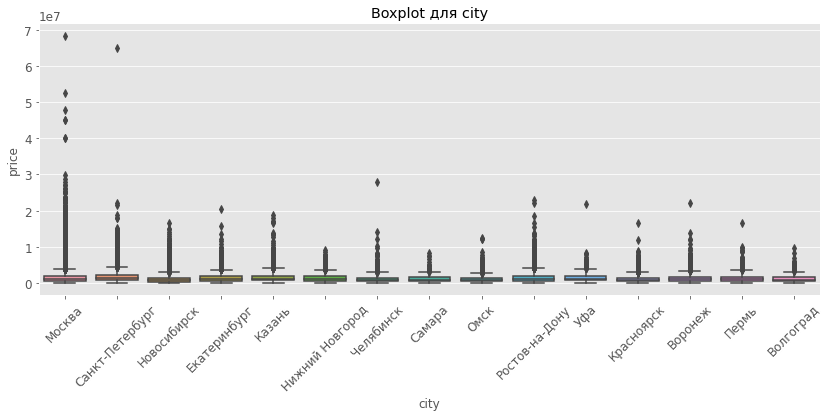

In [378]:
# посмотрим зависимости категориальных признаков от цены
for col in (bin_cols + cat_cols):    
    fig, ax = plt.subplots(figsize=(14, 5))
    sns.boxplot(x=col, y='price', data=df[df['train'] == 1], ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot для ' + col)
    plt.show()

Выводы:
1. Есть несбалансированные признаки: ПТС (оригинал или дубликат), с какой стороны руль (левой или правой), марка японская или европейская, тип кузова и марка авто, тип топлива, тип привода.
2. Зависимость с целевой переменной: европейские машины дороже, автомобили с правым рулем в среднем дешевле, автомобили с автоматической коробкой в средем дороже автомобилей с механикой, автомобили с оригинальным ПТС также дороже автомобилей с дубликатом ПТС.

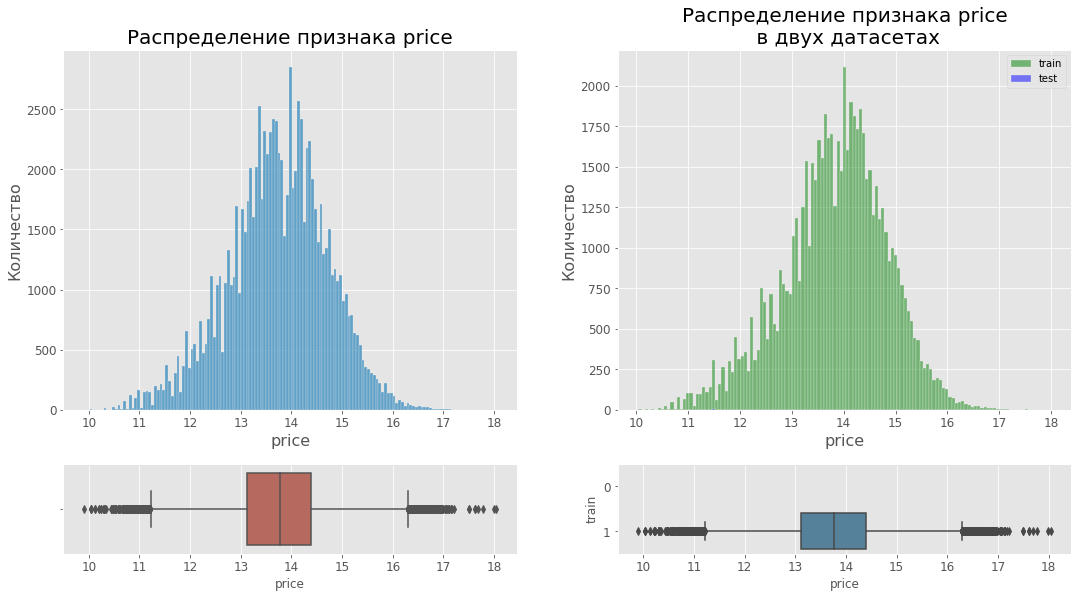

In [379]:
# цены прологарифмируем
df.price = np.log(df.price)
numeric_visualization('price')

In [380]:
# некоторые признаки не показали улучшения моделей, их закомментировал

# добавим столбец с признаком возраста авто
df['year'] = df.new_data.apply(lambda x: 2021 if x==1 else 2020)
# df['car_age'] = df.year - df.productionDate
# num_cols.append('car_age')

# добавим колонку с признаком среднегодового пробега автомобиля
# df['avg_mileage_per_year'] = df.apply(avg_mileage_per_year, axis=1)
# num_cols.append('avg_mileage_per_year')

# добавим признак, через сколько лет после начала производства выпущено авто
df['prod_age'] = df.productionDate - df.modelDate
num_cols.append('prod_age')

#### добавим признак раритетности автомобиля
Классификация Международной федерации старинных автомобилей (FIVA)
FIVA (Fédération Internationale des Véhicules Anciens) выделяет следующие категории старинных автомобилей по годам выпуска[1]:

 - Class A (Ancestor) — выпуска до 31 декабря 1904 года
 - Class B (Veteran) — с 1 января 1905 по 31 декабря 1918
 - Class C (Vintage) — с 1 января 1919 по 31 декабря 1930
 - Class D (Post Vintage) — с 1 января 1931 по 31 декабря 1945
 - Class E (Post War) — с 1 января 1946 по 31 декабря 1960
 - Class F — с 1 января 1961 по 31 декабря 1970
 - Class G — с 1 января 1971 и вплоть до минимального возраста, установленного FIVA — 30 лет.

In [381]:
# Значения:

# 0 - авто нераритетный
# 1 - Class F — с 1 января 1961 по 31 декабря 1970
# 2 - Class E (Post War) — с 1 января 1946 по 31 декабря 1960
# 3 - Class D (Post Vintage) — с 1 января 1931 по 31 декабря 1945
# 4 - Class C (Vintage) — с 1 января 1919 по 31 декабря 1930
# 5 - Class B (Veteran) — с 1 января 1905 по 31 декабря 1918 (таких авто в выборке нет)
# 6 - Class A (Ancestor) — выпуска до 31 декабря 1904 года.
df['rarity'] = df.productionDate.apply(rarity)
num_cols.append('rarity')

In [382]:
# добавим признак категории транспортного налога в зависимости от мощности авто
# df['tax_category'] = df.apply(tax_category, axis=1)
# num_cols.append('tax_category')

# добавим признак популярности типа кузова
# df['top_bodyType'] = df.bodyType.apply(lambda x: 1 if x in ['внедорожник', 'седан'] else 0)
# bin_cols.append('top_bodyType')

# добавим признак непопулярности типа кузова
# df['no_top_bodyType'] = df.bodyType.apply(lambda x: 1 if x in ['фургон', 'родстер', 'кабриолет', 'лимузин'] else 0)
# bin_cols.append('no_top_bodyType')

# добавим признак популярности цвета
# df['top_color'] = df.color.apply(lambda x: 1 if x in ['черный', 'белый', 'серый', 'синий', 'серебристый'] else 0)
# bin_cols.append('top_color')

# добавим признак непопулярности цвета
# df['no_top_color'] = df.color.apply(lambda x: 1 if x in ['фиолетовый', 'пурпурный', 'золотистый', 'оранжевый', 'жёлтый', 'розовый'] else 0)
# bin_cols.append('no_top_color')

# добавим признак популярности количества дверей
# df['top_door_num'] = df.numberOfDoors.apply(lambda x: 1 if x in [4, 5] else 0)
# bin_cols.append('top_door_num')

In [383]:
# добавим признак популярности модели авто
model_dict = {}

for item in df.brand.unique():
    model_df = pd.DataFrame(df[df.brand == item]['model_name'].value_counts())
    # Среднее по всем значениям моделей бренда
    mean_model = df[df.brand == item]['model_name'].value_counts().values.mean()
    # Добавляем признак во временный датафрейм
    model_df['modelPopular'] = model_df.model_name.apply(
        lambda x: 1 if x >= mean_model else 0)
    # Удалим ненужный столбец
    model_df.drop('model_name', axis=1, inplace=True)
    # Создаем словарь популярности брендов
    dict_model_per_brand = model_df.to_dict()['modelPopular']
    model_dict.update(dict_model_per_brand)

# Создаем новый признак
df['modelPopular'] = df.model_name.copy()
df['modelPopular'].replace(to_replace=model_dict, inplace=True)
bin_cols.append('modelPopular')

In [384]:
# логарифмирования признаков не улучшили модель

# # признак объема двигателя прологарифмируем
# df.engineDisplacement = np.log(df.engineDisplacement + 0.001)
# numeric_visualization('engineDisplacement')

# # признак мощности авто прологарифмируем
# df.enginePower = np.log(df.enginePower)
# numeric_visualization('enginePower')

# # признак пробега автомобиля прологарифмируем
# df.mileage = np.log(df.mileage)
# numeric_visualization('mileage')

In [385]:
# сделаем копию датасета
df_copy = df.copy()

## LabelEncoder

In [386]:
# бинарные и категориальные признаки перекодируем в LabelEncoder
le = LabelEncoder()
for col in bin_cols:
    df[col] = le.fit_transform(df[col])
    print(dict(zip(le.classes_, le.transform(le.classes_))))

for col in cat_cols:
    df[col] = le.fit_transform(df[col])
    print(dict(zip(le.classes_, le.transform(le.classes_))))

{'EUROPEAN': 0, 'JAPANESE': 1}
{'Дубликат': 0, 'Оригинал': 1}
{'Левый': 0, 'Правый': 1}
{'Не требует ремонта': 0, 'Нет данных': 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{'внедорожник': 0, 'кабриолет': 1, 'купе': 2, 'лимузин': 3, 'лифтбек': 4, 'минивэн': 5, 'пикап': 6, 'родстер': 7, 'седан': 8, 'универсал': 9, 'фургон': 10, 'хэтчбек': 11}
{'AUDI': 0, 'BMW': 1, 'HONDA': 2, 'INFINITI': 3, 'LEXUS': 4, 'MERCEDES': 5, 'MITSUBISHI': 6, 'NISSAN': 7, 'SKODA': 8, 'TOYOTA': 9, 'VOLKSWAGEN': 10, 'VOLVO': 11}
{'бежевый': 0, 'белый': 1, 'голубой': 2, 'жёлтый': 3, 'зелёный': 4, 'золотистый': 5, 'коричневый': 6, 'красный': 7, 'оранжевый': 8, 'пурпурный': 9, 'розовый': 10, 'серебристый': 11, 'серый': 12, 'синий': 13, 'фиолетовый': 14, 'чёрный': 15}
{'бензин': 0, 'газ': 1, 'гибрид': 2, 'дизель': 3, 'электро': 4}
{'автоматическая': 0, 'вариатор': 1, 'механическая': 2, 'роботизированная': 3}
{'задний': 0, 'передний': 1, 'полный': 2}
{'02': 0, '100': 1, '100NX': 2, '100_SERIES': 3, '120': 4, '1200': 5, '140': 6, '164'

In [387]:
df

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,ownersCount,ownershipTime,tcp,drivetrain,driveSide,condition,customs,price,city,train,new_data,year,prod_age,rarity,modelPopular
0,8,2,https://auto.ru/cars/used/sale/honda/accord/11...,11,NaN,"Машина в максимальной комплектации: кожа, люк,...",2.4,190.0,"{'cruise-control': True, 'asr': True, 'tinted-...",0,https://avatars.mds.yandex.net/get-autoru-vos/...,198781.0,2002.0,"{'code': 'ACCORD', 'name': 'Accord', 'ru_name'...",54,2.4 AT (190 л.с.),4.0,2005.0,1.105910e+09,"{'id': '20495769', 'displacement': 2354, 'engi...",SEDAN AUTOMATIC 2.4,0,1,3.0,1 год и 4 месяца,1,1,0,0,Растаможен,13.234620,5,1,1,2021,3.0,0,1
1,8,2,https://auto.ru/cars/used/sale/honda/civic/110...,11,NaN,Автомобиль был куплен новым у официального дил...,1.8,140.0,"{'engine-proof': True, 'asr': True, 'tinted-gl...",0,https://avatars.mds.yandex.net/get-autoru-vos/...,200000.0,2005.0,"{'code': 'CIVIC', 'name': 'Civic', 'ru_name': ...",127,1.8 MT (140 л.с.),4.0,2008.0,1.105428e+09,"{'id': '2306778', 'displacement': 1798, 'engin...",SEDAN MECHANICAL 1.8,2,1,3.0,NaN,1,1,0,0,Растаможен,13.047640,5,1,1,2021,3.0,0,1
2,0,2,https://auto.ru/cars/used/sale/honda/cr_v/1105...,6,NaN,"Продаю семейный автомобиль, который служил всё...",2.0,150.0,"{'electro-window-back': True, 'paint-metallic'...",0,https://autoru.naydex.net/Bzqs85G78/1a23943g/j...,106000.0,2009.0,"{'code': 'CR_V', 'name': 'CR-V', 'ru_name': 'C...",161,2.0 MT (150 л.с.) 4WD,5.0,2011.0,1.105765e+09,"{'id': '6312920', 'displacement': 1997, 'engin...",ALLROAD_5_DOORS MECHANICAL 2.0,2,1,1.0,NaN,1,2,0,0,Растаможен,14.077875,5,1,1,2021,2.0,0,1
3,0,2,https://auto.ru/cars/used/sale/honda/hr_v/1105...,7,NaN,В хорошем состоянии!На уверенном ходу!\nЮр.чис...,1.6,105.0,"{'asr': True, 'tinted-glass': True, 'esp': Tru...",0,https://autoru.naydex.net/Bzqs85G78/1a23943g/j...,250000.0,2001.0,"{'code': 'HR_V', 'name': 'HR-V', 'ru_name': 'H...",272,1.6 CVT (105 л.с.) 4WD,5.0,2003.0,1.105847e+09,"{'id': '6471712', 'displacement': 1590, 'engin...",ALLROAD_5_DOORS VARIATOR 1.6,1,1,3.0,NaN,0,2,0,0,Растаможен,12.745486,5,1,1,2021,2.0,0,1
4,8,2,https://auto.ru/cars/used/sale/honda/accord/11...,13,NaN,Honda Accord 1998 года. 1 владелец. Двигатель ...,1.9,136.0,{},0,https://autoru.naydex.net/Bzqs85G78/1a23943g/j...,300000.0,1997.0,"{'code': 'ACCORD', 'name': 'Accord', 'ru_name'...",54,1.9 AT (136 л.с.),4.0,1998.0,1.105414e+09,"{'id': '6307020', 'displacement': 1849, 'engin...",SEDAN AUTOMATIC 1.9,0,1,1.0,10 лет и 9 месяцев,1,1,0,0,Растаможен,12.301383,5,1,1,2021,1.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130519,2,5,NaN,15,{'id': '0'},"Автомобиль отреставрирован в Kienle, состояние...",3.0,150.0,NaN,0,NaN,12000.0,1951.0,NaN,619,3.0 MT (150 л.с.),2.0,1952.0,NaN,NaN,COUPE MECHANICAL 3.0,2,0,3.0,"{'year': 2015, 'month': 6}",1,0,0,1,True,17.776324,5,1,0,2020,1.0,2,0
130520,8,5,NaN,15,{'id': '0'},Легендарный Mercedes Benz 300 w189 лимузин. В ...,3.0,160.0,NaN,0,NaN,10000.0,1957.0,NaN,620,3.0 AT (160 л.с.),4.0,1959.0,NaN,NaN,SEDAN AUTOMATIC 3.0,0,0,2.0,NaN,1,0,0,1,True,15.538277,5,1,0,2020,2.0,2,0
130521,6,5,NaN,12,{'id': '0'},"Пробег 900км (обкатка), комплектация X-line Po...",3.0,258.0,NaN,3,NaN,800.0,2017.0,NaN,643,350 d 3.0d AT (258 л.с.) 4WD,4.0,2018.0,NaN,NaN,PICKUP_TWO AUTOMATIC 350,0,0,1.0,"{'year': 2019, 'month': 12}",1,2,0,1,True,15.201805,5,1,0,2020,1.0,0,0
130522,6,5,NaN,12,"{'id': '21277397', 'name': '250 d 4MATIC POWER...","Состояние новой машины , дополнительно установ...",2.3,190.0,NaN,3,NaN,15850.0,2017.0,NaN,643,250 d 2.3d AT (190 л.с.) 4WD,4.0,2018.0,NaN,NaN,PICKUP_TWO AUTOMATIC 250,0,0,1.0,NaN,1,2,0,1,True,14.962913,5,1,0,2020,1.0,0,0


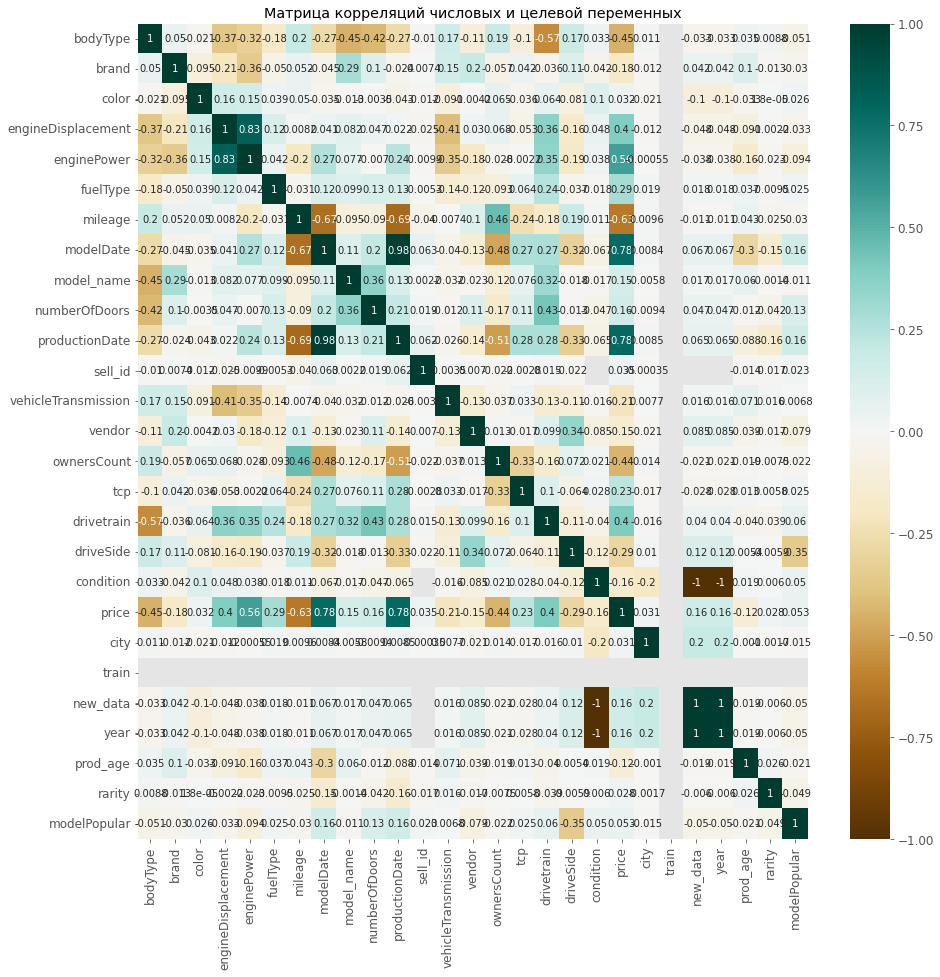

In [388]:
# Построим матрицу корреляций
plt.figure(figsize=(15, 15))
heatmap = sns.heatmap(df[df['train'] == 1].corr(),
                      vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Матрица корреляций числовых и целевой переменных')
plt.show()

Из тепловой карты корреляций можно видеть, что есть признаки, у которых достаточно высокое значение корреляции: productionDate и modelDate; productionDate и mileage; engineDisplacement и enginePower. Проведенные эксперименты показали, что удаление признаков, которые порождают высокие значения корреляции не только не приводят к улучшению результата, но и ухудшают его, хоть и незначительно.

In [389]:
# список признаков на удаление
col_drop = ['car_url', 'complectation_dict', 'description', 'equipment_dict', 'image', 'model_info', 'name',
           'super_gen', 'vehicleConfiguration', 'ownershipTime', 'customs', 'year']
# удаляем ненужные колонки
df = df.drop(col_drop, axis=1)

In [390]:
df

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,sell_id,vehicleTransmission,vendor,ownersCount,tcp,drivetrain,driveSide,condition,price,city,train,new_data,prod_age,rarity,modelPopular
0,8,2,11,2.4,190.0,0,198781.0,2002.0,54,4.0,2005.0,1.105910e+09,0,1,3.0,1,1,0,0,13.234620,5,1,1,3.0,0,1
1,8,2,11,1.8,140.0,0,200000.0,2005.0,127,4.0,2008.0,1.105428e+09,2,1,3.0,1,1,0,0,13.047640,5,1,1,3.0,0,1
2,0,2,6,2.0,150.0,0,106000.0,2009.0,161,5.0,2011.0,1.105765e+09,2,1,1.0,1,2,0,0,14.077875,5,1,1,2.0,0,1
3,0,2,7,1.6,105.0,0,250000.0,2001.0,272,5.0,2003.0,1.105847e+09,1,1,3.0,0,2,0,0,12.745486,5,1,1,2.0,0,1
4,8,2,13,1.9,136.0,0,300000.0,1997.0,54,4.0,1998.0,1.105414e+09,0,1,1.0,1,1,0,0,12.301383,5,1,1,1.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130519,2,5,15,3.0,150.0,0,12000.0,1951.0,619,2.0,1952.0,NaN,2,0,3.0,1,0,0,1,17.776324,5,1,0,1.0,2,0
130520,8,5,15,3.0,160.0,0,10000.0,1957.0,620,4.0,1959.0,NaN,0,0,2.0,1,0,0,1,15.538277,5,1,0,2.0,2,0
130521,6,5,12,3.0,258.0,3,800.0,2017.0,643,4.0,2018.0,NaN,0,0,1.0,1,2,0,1,15.201805,5,1,0,1.0,0,0
130522,6,5,12,2.3,190.0,3,15850.0,2017.0,643,4.0,2018.0,NaN,0,0,1.0,1,2,0,1,14.962913,5,1,0,1.0,0,0


## Model

In [391]:
df_test = df[df.train == 0]
df_train = df[df.train == 1]
# удаляем ненужные колонки
df_test = df_test.drop(['sell_id', 'train', 'price'], axis=1)
df_train = df_train.drop(['sell_id', 'train'], axis=1)
print(df_test.shape)
print(df_train.shape)

(34686, 23)
(95838, 24)


In [392]:
# Нормализация данных
scaler = StandardScaler()
for col in (num_cols):
    df_train[col] = scaler.fit_transform(df_train[[col]])
    df_test[col] = scaler.transform(df_test[[col]])

In [393]:
X = df_train.drop('price', axis=1)
y = df_train.price

# разделим выборку так, чтобы новые и старые данные были в одинаковой пропорции
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=RANDOM_SEED,
                                                    stratify=X['new_data'])

### Наивная модель

Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). C ней будем сравнивать другие модели.

In [394]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(df_train.groupby('engineDisplacement')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(np.exp(y_test), np.exp(predict.values)))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 96.44%


In [395]:
X_train

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,vehicleTransmission,vendor,ownersCount,tcp,drivetrain,driveSide,condition,city,new_data,prod_age,rarity,modelPopular
39680,0,8,1,-1.225908,-0.910679,0,-0.445381,0.168744,647,0.752548,0.023299,3,0,0.940894,0,1,0,0,7,1,-0.693879,-0.019708,1
102069,8,0,15,0.467545,0.063639,0,0.486363,0.040341,51,-0.721118,-0.244484,1,0,-0.248980,1,1,0,1,5,0,-1.302458,-0.019708,1
21990,8,10,15,-0.590863,-0.050987,0,-1.099790,0.810757,390,-0.721118,0.960540,3,0,-1.438854,1,1,0,0,5,1,0.523278,-0.019708,1
105685,8,1,1,0.467545,0.098027,0,1.133576,-1.757297,37,-0.721118,-1.717293,0,0,0.940894,0,0,0,1,5,0,0.523278,-0.019708,1
102138,9,0,13,0.679226,0.453366,3,0.128948,-0.473270,51,0.752548,-0.646159,0,0,0.940894,1,2,0,1,5,0,-0.693879,-0.019708,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54224,0,1,1,0.679226,0.533604,0,1.519971,-1.115283,633,0.752548,-1.181726,0,0,0.940894,0,2,0,0,10,1,-0.085301,-0.019708,1
20595,8,10,13,-0.802545,-0.910679,0,-0.624524,0.168744,405,-0.721118,0.424974,0,0,-1.438854,1,1,0,0,5,1,1.131857,-0.019708,1
38400,8,9,12,-0.379182,-0.417789,0,0.293166,0.425549,107,-0.721118,0.558865,0,1,0.940894,0,1,0,0,7,1,0.523278,-0.019708,1
65549,0,2,13,-0.802545,-0.910679,0,-0.153121,-0.858478,272,0.752548,-0.780051,1,1,-0.248980,1,2,0,0,0,1,0.523278,-0.019708,1


Далее представлено несколько экспериментов с различными настроенными моделями. Все модели с дефолтными параметрами показывают переобучение. Настраивал модели первоначально при помощи RandomizedSearchCV, а затем еще менял некоторые параметры, чтобы уменьшить переобучение. Все модели настраивал парралельно на нескольких ноутбуках, здесь собрал уже с настроенными параметрами.

### CatBoostRegressor

In [396]:
cbr = CatBoostRegressor(iterations=10000, learning_rate=0.01, depth=7,
                        random_seed=RANDOM_SEED, loss_function='MAPE',
                        eval_metric='MAPE', od_type='Iter', od_wait=20,
                        metric_period=500, random_strength=0.3,
                        l2_leaf_reg=0.15)

In [397]:
cbr.fit(X_train, y_train, cat_features=cat_cols, eval_set=(X_test, y_test))

0:	learn: 0.0570905	test: 0.0567337	best: 0.0567337 (0)	total: 121ms	remaining: 20m 10s
500:	learn: 0.0128229	test: 0.0128031	best: 0.0128031 (500)	total: 47.2s	remaining: 14m 55s
1000:	learn: 0.0112909	test: 0.0113362	best: 0.0113362 (1000)	total: 1m 33s	remaining: 13m 57s
1500:	learn: 0.0105740	test: 0.0106623	best: 0.0106623 (1500)	total: 2m 19s	remaining: 13m 7s
2000:	learn: 0.0101397	test: 0.0102955	best: 0.0102955 (2000)	total: 3m 5s	remaining: 12m 20s
2500:	learn: 0.0098594	test: 0.0100741	best: 0.0100741 (2500)	total: 3m 51s	remaining: 11m 34s
3000:	learn: 0.0096573	test: 0.0099259	best: 0.0099259 (3000)	total: 4m 38s	remaining: 10m 50s
3500:	learn: 0.0095016	test: 0.0098267	best: 0.0098267 (3500)	total: 5m 25s	remaining: 10m 4s
4000:	learn: 0.0093704	test: 0.0097534	best: 0.0097534 (4000)	total: 6m 13s	remaining: 9m 19s
4500:	learn: 0.0092663	test: 0.0097026	best: 0.0097026 (4500)	total: 7m	remaining: 8m 33s
5000:	learn: 0.0091791	test: 0.0096623	best: 0.0096623 (5000)	total: 

In [398]:
predict = np.exp(cbr.predict(X_train))
print(f"Точность модели на обучающей выборке: {(mape(np.exp(y_train), predict))*100:0.2f}%")
predict = np.exp(cbr.predict(X_test))
print(f"Точность модели на проверочной выборке: {(mape(np.exp(y_test), predict))*100:0.2f}%")


Точность модели на обучающей выборке: 11.90%
Точность модели на проверочной выборке: 12.74%


### RandomForestRegressor

In [399]:
rf = RandomForestRegressor(random_state=RANDOM_SEED, max_depth=14,
                           min_samples_leaf=2, n_estimators=350, max_features=12,
                           n_jobs=-1)
rf.fit(X_train, y_train)
predict = np.exp(rf.predict(X_train))
print(f"Точность модели на обучающей выборке: {(mape(np.exp(y_train), predict))*100:0.2f}%")
predict = np.exp(rf.predict(X_test))
print(f"Точность модели на проверочной выборке: {(mape(np.exp(y_test), predict))*100:0.2f}%")

Точность модели на обучающей выборке: 10.81%
Точность модели на проверочной выборке: 13.65%


### ExtraTreesRegressor

In [400]:
etr = ExtraTreesRegressor(random_state=RANDOM_SEED, max_depth=13,
                          min_samples_split=10, min_samples_leaf=5,
                          max_features=23, n_jobs=-1)
etr.fit(X_train, y_train)
predict = np.exp(etr.predict(X_train))
print(f"Точность модели на обучающей выборке: {(mape(np.exp(y_train), predict))*100:0.2f}%")
predict = np.exp(etr.predict(X_test))
print(f"Точность модели на проверочной выборке: {(mape(np.exp(y_test), predict))*100:0.2f}%")

Точность модели на обучающей выборке: 13.42%
Точность модели на проверочной выборке: 14.84%


### LGBM Regressor

In [401]:
lgbm = LGBMRegressor(objective='regression', max_depth=12, num_leaves=1000,
                      learning_rate=0.01, n_estimators=22000, metric='mape',
                      feature_fraction=0.6, random_state=RANDOM_SEED)

lgbm.fit(X_train, y_train, eval_set=(X_test, y_test),
         early_stopping_rounds=20)
predict = np.exp(lgbm.predict(X_train))
print(f"Точность модели на обучающей выборке: {(mape(np.exp(y_train), predict))*100:0.2f}%")
predict = np.exp(lgbm.predict(X_test))
print(f"Точность модели на проверочной выборке: {(mape(np.exp(y_test), predict))*100:0.2f}%")

[1]	valid_0's mape: 0.0566631
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's mape: 0.0561317
[3]	valid_0's mape: 0.055611
[4]	valid_0's mape: 0.0550972
[5]	valid_0's mape: 0.0545842
[6]	valid_0's mape: 0.0540767
[7]	valid_0's mape: 0.053596
[8]	valid_0's mape: 0.0531463
[9]	valid_0's mape: 0.0526476
[10]	valid_0's mape: 0.0521544
[11]	valid_0's mape: 0.0516683
[12]	valid_0's mape: 0.0512861
[13]	valid_0's mape: 0.050807
[14]	valid_0's mape: 0.0504012
[15]	valid_0's mape: 0.0499732
[16]	valid_0's mape: 0.0495096
[17]	valid_0's mape: 0.0490642
[18]	valid_0's mape: 0.0486389
[19]	valid_0's mape: 0.0482301
[20]	valid_0's mape: 0.047781
[21]	valid_0's mape: 0.0473365
[22]	valid_0's mape: 0.0469055
[23]	valid_0's mape: 0.0464688
[24]	valid_0's mape: 0.0460824
[25]	valid_0's mape: 0.0456568
[26]	valid_0's mape: 0.0452377
[27]	valid_0's mape: 0.0448214
[28]	valid_0's mape: 0.0444105
[29]	valid_0's mape: 0.0440309
[30]	valid_0's mape: 0.0436295
[31]	valid_0's mape: 

### XGBoost Regressor

In [402]:
xgb = XGBRegressor(random_state=RANDOM_SEED, n_jobs=-1,
                   objective='reg:squarederror', learning_rate=0.01,
                   n_estimators=6000, max_depth=5, colsample_bytree=0.4,
                   silent=1)
xgb.fit(X_train, y_train)
predict = np.exp(xgb.predict(X_train))
print(f"Точность модели на обучающей выборке: {(mape(np.exp(y_train), predict))*100:0.2f}%")
predict = np.exp(xgb.predict(X_test))
print(f"Точность модели на проверочной выборке: {(mape(np.exp(y_test), predict))*100:0.2f}%")

Точность модели на обучающей выборке: 11.99%
Точность модели на проверочной выборке: 13.07%


### GradientBoostingRegressor

In [403]:
gbr = GradientBoostingRegressor(random_state=RANDOM_SEED, n_estimators=500,
                                min_samples_leaf=4, max_features='auto',
                                max_depth=10, learning_rate=0.01,
                                min_samples_split=3)
gbr.fit(X_train, y_train)
predict = np.exp(gbr.predict(X_train))
print(f"Точность модели на обучающей выборке: {(mape(np.exp(y_train), predict))*100:0.2f}%")
predict = np.exp(gbr.predict(X_test))
print(f"Точность модели на проверочной выборке: {(mape(np.exp(y_test), predict))*100:0.2f}%")

Точность модели на обучающей выборке: 10.59%
Точность модели на проверочной выборке: 13.48%


### HistGradientBoostingRegressor

In [404]:
hgbr = HistGradientBoostingRegressor(random_state=RANDOM_SEED,
                                     min_samples_leaf=5, max_leaf_nodes=100,
                                     max_iter=400, max_depth=30, learning_rate=0.01)
hgbr.fit(X_train, y_train)
predict = np.exp(hgbr.predict(X_train))
print(f"Точность модели на обучающей выборке: {(mape(np.exp(y_train), predict))*100:0.2f}%")
predict = np.exp(hgbr.predict(X_test))
print(f"Точность модели на проверочной выборке: {(mape(np.exp(y_test), predict))*100:0.2f}%")

Точность модели на обучающей выборке: 14.83%
Точность модели на проверочной выборке: 15.35%


### Bagging Regressor

In [ ]:
# дефолтные параметры
br = BaggingRegressor(random_state=RANDOM_SEED)
br.fit(X_train, y_train)
predict = np.exp(br.predict(X_train))
print(f"Точность модели на обучающей выборке: {(mape(np.exp(y_train), predict))*100:0.2f}%")
predict = np.exp(br.predict(X_test))
print(f"Точность модели на проверочной выборке: {(mape(np.exp(y_test), predict))*100:0.2f}%")

Точность модели на обучающей выборке: 5.71%
Точность модели на проверочной выборке: 14.51%


In [ ]:
# + RandomForestRegressor
br_rf = BaggingRegressor(random_state=RANDOM_SEED, n_jobs=-1, base_estimator=rf)
br_rf.fit(X_train, y_train)
predict = np.exp(br_rf.predict(X_train))
print(f"Точность модели на обучающей выборке: {(mape(np.exp(y_train), predict))*100:0.2f}%")
predict = np.exp(br_rf.predict(X_test))
print(f"Точность модели на проверочной выборке: {(mape(np.exp(y_test), predict))*100:0.2f}%")

Точность модели на обучающей выборке: 11.60%
Точность модели на проверочной выборке: 13.79%


In [ ]:
# + CatBoostRegressor
br_cbr = BaggingRegressor(random_state=RANDOM_SEED, n_jobs=-1, base_estimator=cbr)
br_cbr.fit(X_train, y_train)
predict = np.exp(br_cbr.predict(X_train))
print(f"Точность модели на обучающей выборке: {(mape(np.exp(y_train), predict))*100:0.2f}%")
predict = np.exp(br_cbr.predict(X_test))
print(f"Точность модели на проверочной выборке: {(mape(np.exp(y_test), predict))*100:0.2f}%")

Точность модели на обучающей выборке: 11.86%
Точность модели на проверочной выборке: 13.10%


In [ ]:
# + ExtraTrees Regressor
br_etr = BaggingRegressor(random_state=RANDOM_SEED, n_jobs=-1, base_estimator=etr)
br_etr.fit(X_train, y_train)
predict = np.exp(br_etr.predict(X_train))
print(f"Точность модели на обучающей выборке: {(mape(np.exp(y_train), predict))*100:0.2f}%")
predict = np.exp(br_etr.predict(X_test))
print(f"Точность модели на проверочной выборке: {(mape(np.exp(y_test), predict))*100:0.2f}%")

Точность модели на обучающей выборке: 13.83%
Точность модели на проверочной выборке: 15.00%


### Stacking Regressor

In [406]:
estimators = [('etr', ExtraTreesRegressor(random_state=RANDOM_SEED,
                                          max_depth=13, min_samples_split=10,
                                          min_samples_leaf=5, max_features=23,
                                          n_jobs=-1)),
              ('rf', RandomForestRegressor(random_state=RANDOM_SEED,
                                           max_depth=14, min_samples_leaf=2,
                                           n_estimators=350, max_features=12,
                                           n_jobs=-1))]

sr_etr_rf_cbr = StackingRegressor(estimators=estimators,
                                   final_estimator=CatBoostRegressor(iterations=10000, learning_rate=0.01,
                                                                     depth=7, random_seed=RANDOM_SEED,
                                                                     loss_function='MAPE', eval_metric='MAPE',
                                                                     od_type='Iter', od_wait=20,
                                                                     metric_period=500, random_strength=0.3,
                                                                     l2_leaf_reg=0.15))

# оцениваем точность
sr_etr_rf_cbr.fit(X_train, y_train)
predict = np.exp(sr_etr_rf_cbr.predict(X_train))
print(f"Точность модели на обучающей выборке: {(mape(np.exp(y_train), predict))*100:0.2f}%")
predict = np.exp(sr_etr_rf_cbr.predict(X_test))
print(f"Точность модели на проверочной выборке: {(mape(np.exp(y_test), predict))*100:0.2f}%")

0:	learn: 0.0570572	total: 11ms	remaining: 1m 49s
500:	learn: 0.0104753	total: 4.58s	remaining: 1m 26s
1000:	learn: 0.0102619	total: 9.07s	remaining: 1m 21s
1500:	learn: 0.0102029	total: 13.6s	remaining: 1m 17s
2000:	learn: 0.0101613	total: 18.1s	remaining: 1m 12s
2500:	learn: 0.0101338	total: 22.7s	remaining: 1m 8s
3000:	learn: 0.0101106	total: 27.2s	remaining: 1m 3s
3500:	learn: 0.0100915	total: 31.8s	remaining: 59.1s
4000:	learn: 0.0100757	total: 36.3s	remaining: 54.5s
4500:	learn: 0.0100616	total: 40.8s	remaining: 49.9s
5000:	learn: 0.0100495	total: 45.3s	remaining: 45.3s
5500:	learn: 0.0100385	total: 49.8s	remaining: 40.8s
6000:	learn: 0.0100286	total: 54.4s	remaining: 36.3s
6500:	learn: 0.0100193	total: 59s	remaining: 31.8s
7000:	learn: 0.0100109	total: 1m 3s	remaining: 27.2s
7500:	learn: 0.0100033	total: 1m 8s	remaining: 22.7s
8000:	learn: 0.0099960	total: 1m 12s	remaining: 18.2s
8500:	learn: 0.0099892	total: 1m 17s	remaining: 13.6s
9000:	learn: 0.0099829	total: 1m 21s	remaining

In [410]:
estimators = [('cbr', CatBoostRegressor(iterations=10000, learning_rate=0.01,
                                        depth=7, random_seed=RANDOM_SEED,
                                        loss_function='MAPE', eval_metric='MAPE',
                                        od_type='Iter', od_wait=20,
                                        metric_period=500, random_strength=0.3,
                                        l2_leaf_reg=0.15)),
              ('rf', RandomForestRegressor(random_state=RANDOM_SEED,
                                           max_depth=14, min_samples_leaf=2,
                                           n_estimators=350, max_features=12,
                                           n_jobs=-1))]

sr_cbr_rf_cbr = StackingRegressor(estimators=estimators,
                                  final_estimator=CatBoostRegressor(iterations=10000, learning_rate=0.01,
                                                                     depth=7, random_seed=RANDOM_SEED,
                                                                     loss_function='MAPE', eval_metric='MAPE',
                                                                     od_type='Iter', od_wait=20,
                                                                     metric_period=500, random_strength=0.3,
                                                                     l2_leaf_reg=0.15))

# оцениваем точность
sr_cbr_rf_cbr.fit(X_train, y_train)
predict = np.exp(sr_cbr_rf_cbr.predict(X_train))
print(f"Точность модели на обучающей выборке: {(mape(np.exp(y_train), predict))*100:0.2f}%")
predict = np.exp(sr_cbr_rf_cbr.predict(X_test))
print(f"Точность модели на проверочной выборке: {(mape(np.exp(y_test), predict))*100:0.2f}%")

0:	learn: 0.0570966	total: 14ms	remaining: 2m 19s
500:	learn: 0.0129463	total: 6.17s	remaining: 1m 56s
1000:	learn: 0.0113828	total: 12.1s	remaining: 1m 49s
1500:	learn: 0.0106715	total: 18.1s	remaining: 1m 42s
2000:	learn: 0.0102278	total: 24.2s	remaining: 1m 36s
2500:	learn: 0.0099481	total: 30.2s	remaining: 1m 30s
3000:	learn: 0.0097272	total: 36.2s	remaining: 1m 24s
3500:	learn: 0.0095401	total: 42.2s	remaining: 1m 18s
4000:	learn: 0.0093803	total: 48.2s	remaining: 1m 12s
4500:	learn: 0.0092474	total: 54.2s	remaining: 1m 6s
5000:	learn: 0.0091349	total: 1m	remaining: 1m
5500:	learn: 0.0090318	total: 1m 6s	remaining: 54s
6000:	learn: 0.0089383	total: 1m 12s	remaining: 48s
6500:	learn: 0.0088562	total: 1m 17s	remaining: 41.9s
7000:	learn: 0.0087823	total: 1m 23s	remaining: 35.9s
7500:	learn: 0.0087124	total: 1m 29s	remaining: 29.9s
8000:	learn: 0.0086471	total: 1m 35s	remaining: 23.9s
8500:	learn: 0.0085874	total: 1m 41s	remaining: 17.9s
9000:	learn: 0.0085347	total: 1m 47s	remaining

In [412]:
estimators = [('cbr', CatBoostRegressor(iterations=10000, learning_rate=0.01,
                                        depth=7, random_seed=RANDOM_SEED,
                                        loss_function='MAPE', eval_metric='MAPE',
                                        od_type='Iter', od_wait=20,
                                        metric_period=500, random_strength=0.3,
                                        l2_leaf_reg=0.15))]

sr_cbr_cbr = StackingRegressor(estimators=estimators,
                                  final_estimator=CatBoostRegressor(iterations=10000, learning_rate=0.01,
                                                                     depth=7, random_seed=RANDOM_SEED,
                                                                     loss_function='MAPE', eval_metric='MAPE',
                                                                     od_type='Iter', od_wait=20,
                                                                     metric_period=500, random_strength=0.3,
                                                                     l2_leaf_reg=0.15))

# оцениваем точность
sr_cbr_cbr.fit(X_train, y_train)
predict = np.exp(sr_cbr_cbr.predict(X_train))
print(f"Точность модели на обучающей выборке: {(mape(np.exp(y_train), predict))*100:0.2f}%")
predict = np.exp(sr_cbr_cbr.predict(X_test))
print(f"Точность модели на проверочной выборке: {(mape(np.exp(y_test), predict))*100:0.2f}%")

0:	learn: 0.0570966	total: 14.2ms	remaining: 2m 21s
500:	learn: 0.0129463	total: 6.16s	remaining: 1m 56s
1000:	learn: 0.0113828	total: 12.1s	remaining: 1m 48s
1500:	learn: 0.0106715	total: 18.1s	remaining: 1m 42s
2000:	learn: 0.0102278	total: 24.1s	remaining: 1m 36s
2500:	learn: 0.0099481	total: 30s	remaining: 1m 30s
3000:	learn: 0.0097272	total: 36s	remaining: 1m 23s
3500:	learn: 0.0095401	total: 42s	remaining: 1m 17s
4000:	learn: 0.0093803	total: 47.9s	remaining: 1m 11s
4500:	learn: 0.0092474	total: 53.9s	remaining: 1m 5s
5000:	learn: 0.0091349	total: 59.8s	remaining: 59.8s
5500:	learn: 0.0090318	total: 1m 5s	remaining: 53.8s
6000:	learn: 0.0089383	total: 1m 11s	remaining: 47.8s
6500:	learn: 0.0088562	total: 1m 17s	remaining: 41.8s
7000:	learn: 0.0087823	total: 1m 23s	remaining: 35.8s
7500:	learn: 0.0087124	total: 1m 29s	remaining: 29.8s
8000:	learn: 0.0086471	total: 1m 35s	remaining: 23.8s
8500:	learn: 0.0085874	total: 1m 41s	remaining: 17.9s
9000:	learn: 0.0085347	total: 1m 47s	rem

In [414]:
estimators = [('cbr', CatBoostRegressor(iterations=10000, learning_rate=0.01,
                                        depth=7, random_seed=RANDOM_SEED,
                                        loss_function='MAPE', eval_metric='MAPE',
                                        od_type='Iter', od_wait=20,
                                        metric_period=500, random_strength=0.3,
                                        l2_leaf_reg=0.15)),
              ('rf', RandomForestRegressor(random_state=RANDOM_SEED,
                                           max_depth=14, min_samples_leaf=2,
                                           n_estimators=350, max_features=12,
                                           n_jobs=-1))]

sr_cbr_rf_etr = StackingRegressor(estimators=estimators,
                                  final_estimator=ExtraTreesRegressor(random_state=RANDOM_SEED,
                                                                      max_depth=10, n_jobs=-1))

# оцениваем точность
sr_cbr_rf_etr.fit(X_train, y_train)
predict = np.exp(sr_cbr_rf_etr.predict(X_train))
print(f"Точность модели на обучающей выборке: {(mape(np.exp(y_train), predict))*100:0.2f}%")
predict = np.exp(sr_cbr_rf_etr.predict(X_test))
print(f"Точность модели на проверочной выборке: {(mape(np.exp(y_test), predict))*100:0.2f}%")

0:	learn: 0.0570966	total: 14.2ms	remaining: 2m 22s
500:	learn: 0.0129463	total: 6.12s	remaining: 1m 56s
1000:	learn: 0.0113828	total: 12s	remaining: 1m 48s
1500:	learn: 0.0106715	total: 18s	remaining: 1m 41s
2000:	learn: 0.0102278	total: 23.9s	remaining: 1m 35s
2500:	learn: 0.0099481	total: 29.8s	remaining: 1m 29s
3000:	learn: 0.0097272	total: 35.7s	remaining: 1m 23s
3500:	learn: 0.0095401	total: 41.7s	remaining: 1m 17s
4000:	learn: 0.0093803	total: 47.6s	remaining: 1m 11s
4500:	learn: 0.0092474	total: 53.6s	remaining: 1m 5s
5000:	learn: 0.0091349	total: 59.4s	remaining: 59.4s
5500:	learn: 0.0090318	total: 1m 5s	remaining: 53.4s
6000:	learn: 0.0089383	total: 1m 11s	remaining: 47.5s
6500:	learn: 0.0088562	total: 1m 17s	remaining: 41.6s
7000:	learn: 0.0087823	total: 1m 23s	remaining: 35.6s
7500:	learn: 0.0087124	total: 1m 28s	remaining: 29.6s
8000:	learn: 0.0086471	total: 1m 34s	remaining: 23.7s
8500:	learn: 0.0085874	total: 1m 40s	remaining: 17.8s
9000:	learn: 0.0085347	total: 1m 46s	r

Лучший показатель на лидерборде в Kaggle продемонстрировал CatBoostRegressor - 15,88%. Округление цен до тысяч рублей также не улучшили показатели, поэтому оставил как есть.

In [427]:
# Посмотрим на каких объявлениях больше всего ошибка.
df = df_copy[df_copy.train==1]
# разделим выборку так, чтобы новые и старые данные были в одинаковой пропорции
_, x_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED,
                             stratify=df['new_data'])
x_test['price'] = np.exp(x_test['price'])

In [428]:
predict = np.exp(cbr.predict(X_test))
x_test['MAPE'] = np.abs((np.exp(y_test) - predict)/np.exp(y_test))*100
x_test['predict'] = predict

In [434]:
x_test['predict'] = x_test['predict'].astype(int)
x_test.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,ownersCount,ownershipTime,tcp,drivetrain,driveSide,condition,customs,price,city,train,new_data,year,prod_age,rarity,modelPopular,MAPE,predict
16504,седан,TOYOTA,https://auto.ru/cars/used/sale/toyota/corolla/...,серый,NaN,Автосалоны не звоните!\n\nПродажа от единствен...,1.6,124.0,"{'engine-proof': True, 'tinted-glass': True, '...",бензин,https://autoru.naydex.net/r1h69BQ30/a6c394X1ze...,225000.0,2010.0,"{'code': 'COROLLA', 'name': 'Corolla', 'ru_nam...",COROLLA,1.6 AT (124 л.с.),4.0,2012.0,1.105654e+09,"{'id': '6279375', 'displacement': 1598, 'engin...",SEDAN AUTOMATIC 1.6,автоматическая,JAPANESE,1.0,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,840000.0,Москва,1,1,2021,2.0,0,1,1.168384,849814
23420,седан,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/pass...,коричневый,NaN,"Продам авто в хорошем состояний, без проблем с...",1.8,152.0,"{'esp': True, 'airbag-driver': True, 'aux': Tr...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,160000.0,2011.0,"{'code': 'PASSAT', 'name': 'Passat', 'ru_name'...",PASSAT,1.8 AMT (152 л.с.),4.0,2012.0,1.105154e+09,"{'id': '7150232', 'displacement': 1798, 'engin...",SEDAN ROBOT 1.8,роботизированная,EUROPEAN,3.0,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,880000.0,Москва,1,1,2021,1.0,0,1,0.298135,882623
122867,седан,VOLKSWAGEN,NaN,чёрный,{'id': '0'},"Авто в отличном состоянии. Машина без аварий ,...",1.6,105.0,NaN,бензин,NaN,86530.0,2009.0,NaN,POLO,1.6 AT (105 л.с.),4.0,2013.0,NaN,NaN,SEDAN AUTOMATIC 1.6,автоматическая,EUROPEAN,1.0,NaN,Оригинал,передний,Левый,Нет данных,True,435000.0,Москва,1,0,2020,4.0,0,1,19.973052,521882
46312,внедорожник,NISSAN,https://auto.ru/cars/used/sale/nissan/juke/110...,жёлтый,NaN,Nissan Juke I Рестайлинг 1.6 CVT (117 л.с.) Вн...,1.6,117.0,"{'cruise-control': True, 'esp': True, 'airbag-...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,31739.0,2014.0,"{'code': 'JUKE', 'name': 'Juke', 'ru_name': 'Д...",JUKE,1.6 CVT (117 л.с.),5.0,2017.0,1.105534e+09,"{'id': '20299557', 'displacement': 1598, 'engi...",ALLROAD_5_DOORS VARIATOR 1.6,вариатор,JAPANESE,2.0,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1460000.0,Казань,1,1,2021,3.0,0,1,4.173204,1399071
49505,седан,AUDI,https://auto.ru/cars/used/sale/audi/a6/1105027...,фиолетовый,NaN,Полный привод на механике. Контрактный двигате...,2.6,150.0,{},бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,391000.0,1994.0,"{'code': 'A6', 'name': 'A6', 'ru_name': 'А6', ...",A6,2.6 MT (150 л.с.) 4WD,4.0,1996.0,1.105028e+09,"{'id': '6456247', 'displacement': 2598, 'engin...",SEDAN MECHANICAL 2.6,механическая,EUROPEAN,3.0,NaN,Дубликат,полный,Левый,Не требует ремонта,Растаможен,200000.0,Нижний Новгород,1,1,2021,2.0,0,1,9.523840,219047


In [435]:
x_test.describe()

,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,productionDate,sell_id,ownersCount,price,train,new_data,year,prod_age,rarity,modelPopular,MAPE,predict
count,19168.000000,19168.000000,19168.000000,19168.000000,19168.000000,19168.000000,1.323600e+04,19168.000000,1.916800e+04,19168.0,19168.000000,19168.000000,19168.000000,19168.000000,19168.000000,19168.000000,1.916800e+04
mean,2.365729,184.981688,162137.892112,2007.699917,4.494626,2009.835716,1.104807e+09,2.205134,1.452200e+06,1.0,0.690526,2020.690526,2.135799,0.001513,0.858358,12.744382,1.419394e+06
std,0.957113,88.179169,103619.514670,7.908619,0.679640,7.556675,4.190775e+06,0.839664,1.709730e+06,0.0,0.462289,0.462289,1.650622,0.059104,0.348692,17.390331,1.530879e+06
min,0.000000,34.000000,1.000000,1936.000000,2.000000,1937.000000,1.005519e+09,1.000000,2.000000e+04,1.0,0.000000,2020.000000,-2.000000,0.000000,0.000000,0.000049,5.713300e+04
25%,1.600000,124.000000,88000.000000,2004.000000,4.000000,2006.000000,1.105182e+09,1.000000,5.000000e+05,1.0,0.000000,2020.000000,1.000000,0.000000,1.000000,3.681012,5.045092e+05
50%,2.000000,163.000000,148000.000000,2009.000000,5.000000,2012.000000,1.105587e+09,2.000000,9.500000e+05,1.0,1.000000,2021.000000,2.000000,0.000000,1.000000,8.074280,9.535215e+05
75%,3.000000,230.000000,216417.500000,2013.000000,5.000000,2015.000000,1.105786e+09,3.000000,1.780630e+06,1.0,1.000000,2021.000000,3.000000,0.000000,1.000000,15.416259,1.766637e+06
max,6.600000,646.000000,1000000.000000,2021.000000,5.000000,2021.000000,1.105924e+09,3.000000,6.500000e+07,1.0,1.000000,2021.000000,45.000000,3.000000,1.000000,339.852397,2.246476e+07


In [440]:
# выведем те строки, на которых МАРЕ больше 100
x_test[x_test.MAPE > 100]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,ownersCount,ownershipTime,tcp,drivetrain,driveSide,condition,customs,price,city,train,new_data,year,prod_age,rarity,modelPopular,MAPE,predict
109197,седан,LEXUS,NaN,зелёный,{'id': '0'},Машина представительского класса.34ЯЫФ Очень м...,4.0,284.0,NaN,бензин,NaN,487000.0,1994.0,NaN,LS,400 4.0 AT (284 л.с.),4.0,1997.0,NaN,NaN,SEDAN AUTOMATIC 400,автоматическая,JAPANESE,2.0,"{'year': 2005, 'month': 10}",Оригинал,задний,Левый,Нет данных,True,170000.0,Москва,1,0,2020,3.0,0,0,128.853463,389050
48757,седан,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/pass...,зелёный,NaN,Продам Пассат на ходу \nНиже рынка на много \n...,1.6,101.0,{},бензин,https://autoru.naydex.net/r1h69BQ30/a6c394X1ze...,200000.0,1996.0,"{'code': 'PASSAT', 'name': 'Passat', 'ru_name'...",PASSAT,1.6 MT (101 л.с.),4.0,1998.0,1.105649e+09,"{'id': '5140509', 'displacement': 1595, 'engin...",SEDAN MECHANICAL 1.6,механическая,EUROPEAN,3.0,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,75000.0,Казань,1,1,2021,2.0,0,1,128.497221,171372
24691,седан,MITSUBISHI,https://auto.ru/cars/used/sale/mitsubishi/gala...,зелёный,NaN,"Автомобиль на ходу, но требует вложений. По ку...",1.8,140.0,"{'condition': True, 'reduce-spare-wheel': True...",бензин,https://autoru.naydex.net/r1h69BQ30/a6c394X1ze...,303000.0,1998.0,"{'code': 'GALANT', 'name': 'Galant', 'ru_name'...",GALANT,1.8 AT (140 л.с.),4.0,1999.0,1.104968e+09,"{'id': '8297385', 'displacement': 1834, 'engin...",SEDAN AUTOMATIC 1.8,автоматическая,JAPANESE,3.0,9 лет и 5 месяцев,Оригинал,передний,Правый,Не требует ремонта,Растаможен,65000.0,Москва,1,1,2021,1.0,0,1,163.240131,171106
103531,купе,BMW,NaN,красный,{'id': '0'},"Всем доброго времени суток !!!\nДа,данный авто...",1.8,113.0,NaN,бензин,NaN,340000.0,1982.0,NaN,3ER,318i 1.8 MT (113 л.с.),2.0,1986.0,NaN,NaN,COUPE MECHANICAL 318i,механическая,EUROPEAN,2.0,NaN,Оригинал,задний,Левый,Нет данных,True,110000.0,Москва,1,0,2020,4.0,0,1,116.238947,237862
124898,седан,VOLVO,NaN,серебристый,{'id': '0'},"Проблем куча,вся информация по телефону. Обмен...",2.4,144.0,NaN,бензин,NaN,230000.0,1991.0,NaN,850,2.4 AT (144 л.с.),4.0,1995.0,NaN,NaN,SEDAN AUTOMATIC 2.4,автоматическая,EUROPEAN,3.0,NaN,Оригинал,передний,Левый,Нет данных,True,50000.0,Москва,1,0,2020,4.0,0,0,129.084868,114542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19226,седан,TOYOTA,https://auto.ru/cars/used/sale/toyota/cresta/1...,бежевый,NaN,Не дымит не пинает Вд не работает почему не ра...,2.5,180.0,{},бензин,https://autoru.naydex.net/Bzqs85G78/1a23943g/j...,100000.0,1992.0,"{'code': 'CRESTA', 'name': 'Cresta', 'ru_name'...",CRESTA,2.5 AT (180 л.с.) 4WD,4.0,1995.0,1.103839e+09,"{'id': '20398843', 'displacement': 2491, 'engi...",SEDAN AUTOMATIC 2.5,автоматическая,JAPANESE,3.0,NaN,Оригинал,полный,Правый,Не требует ремонта,Растаможен,175000.0,Москва,1,1,2021,3.0,0,0,110.199189,367848
52179,универсал,NISSAN,https://auto.ru/cars/used/sale/nissan/ad/11058...,зелёный,NaN,Сразу о грустном — запрет на регистрацию и пот...,1.3,87.0,"{'alloy-wheel-disks': True, 'tinted-glass': Tr...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,120000.0,1999.0,"{'code': 'AD', 'name': 'AD', 'ru_name': 'AD', ...",AD,1.3 AT (87 л.с.),5.0,2001.0,1.105811e+09,"{'id': '20471691', 'displacement': 1295, 'engi...",WAGON_5_DOORS AUTOMATIC 1.3,автоматическая,JAPANESE,3.0,NaN,Оригинал,передний,Правый,Не требует ремонта,Растаможен,80000.0,Омск,1,1,2021,2.0,0,0,126.036213,180828
65641,хэтчбек,AUDI,https://auto.ru/cars/used/sale/audi/a3/1105773...,белый,NaN,"Авто НА ХОДУ,ЗАВОДИТСЯ,ЕДЕТ,НУЖНО ПРЕЛОЖИТЬ РУ...",1.6,101.0,"{'tinted-glass': True, 'abs': True, 'usb': Tru...",бенз

Можно увидеть из описаний ("проблем куча", "запрет на регистрацию", "требует вложений"), что это такие автомобили, которые требуют вложений или продаются на запчасти. Цена на них выставлена ниже рыночной, поэтому модели на них ошибаются. Пробовал убирать такие объявления из выборки, но результат только ухудшился. Наверно, есть такие же объявления и в проверочной части, поэтому удалять такие строки не стал.

In [439]:
# посмотрим статистику по таким авто
x_test[x_test.MAPE > 100].describe()

,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,productionDate,sell_id,ownersCount,price,train,new_data,year,prod_age,rarity,modelPopular,MAPE,predict
count,108.000000,108.00000,108.000000,108.000000,108.000000,108.000000,7.400000e+01,108.000000,108.000000,108.0,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,1.080000e+02
mean,2.143519,129.00000,282274.925926,1989.842593,4.101852,1992.851852,1.104783e+09,2.574074,113231.472222,1.0,0.685185,2020.685185,3.009259,0.037037,0.546296,156.048197,3.097610e+05
std,0.685398,57.25023,155838.310795,9.351058,0.735480,9.055194,3.579315e+06,0.686365,133074.683530,0.0,0.466607,0.466607,2.020897,0.303436,0.500173,54.634673,4.765363e+05
min,1.300000,50.00000,1000.000000,1936.000000,2.000000,1938.000000,1.076494e+09,1.000000,20000.000000,1.0,0.000000,2020.000000,0.000000,0.000000,0.000000,100.213948,6.871200e+04
25%,1.675000,97.75000,200000.000000,1983.750000,4.000000,1987.750000,1.105228e+09,2.000000,55000.000000,1.0,0.000000,2020.000000,2.000000,0.000000,0.000000,114.027038,1.322550e+05
50%,2.000000,113.50000,282880.000000,1991.000000,4.000000,1994.000000,1.105608e+09,3.000000,77000.000000,1.0,1.000000,2021.000000,3.000000,0.000000,1.000000,139.232820,1.863535e+05
75%,2.400000,150.00000,350000.000000,1995.250000,5.000000,1998.000000,1.105779e+09,3.000000,115000.000000,1.0,1.000000,2021.000000,4.000000,0.000000,1.000000,179.515628,2.746920e+05
max,5.000000,347.00000,999999.000000,2016.000000,5.000000,2019.000000,1.105922e+09,3.000000,1000000.000000,1.0,1.000000,2021.000000,9.000000,3.000000,1.000000,339.852397,3.948802e+06


Мы ошибаемся более 100% MAPE на авто в среднем 1993 года, с мощностью двигателя 129 л.с. средней стоиомстью 113000 р.

In [415]:
# Сформируем сабмишн файл
predict_submission = np.exp(cbr.predict(df_test))
submission = pd.read_csv('/content/drive/MyDrive/data/sample_submission.csv')
submission['price'] = predict_submission
submission.to_csv('cbr_submission.csv', index=False)

## SUMMARY

1. Для обогащения данных была проведена работа по парсингу данных с auto.ru. Код парсинга новых данных доступе в отдельном ноутбуке. По результатам парсинга были получены данные для обучающего датасета в размере около 66 тыс. объявлений по всем городам-миллионникам, т. к. объявлений только по Москве собралось очень мало (около 34000). Также были добавлены старые данные, собранные в прошлом году по актуальным для лидерборда ценам. Всего получилось около 95000 объявлений после удаления всех дубликатов.

2. В ходе EDA была проведена очистка и унификация данных, обработка пустых значений, дубликатов. Были созданы новые признаки.

3. По результатам моделирования наилучшую метрику MAPE на данных показала CatBoostRegressor от Yandex. 

4. Стекинг также не улучшил результаты на лидерборде, хотя показал неплохие результаты.

5. По результатам работы на момент 22.11.2021 занимаю 98 позицию на leaderboard (43,75%).

6. Что еще можно было сделать:

*   поискать еще данных с прошлогодними объявлениями, так как из-за разницы в ценах видим, что модель предсказывает в основном бОльшую цену
*   оптимизироваь Stacking